In [ ]:
!pip install --upgrade --force-reinstall numpy==1.26.4 pandas==2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.

In [ ]:
SUBMISSION = 408

from google.colab import drive
drive.mount('/content/drive')

!pip install catboost -q

# Standard libraries
import os
import glob
import time
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle

# Data handling and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine learning and preprocessing
import sklearn
from sklearn.utils.validation import _check_n_features
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
# Model saving/loading
import joblib

# Get the number of CPU threads available
num_threads = multiprocessing.cpu_count()
print(f"Number of CPU threads available: {num_threads}")

# Filepaths
TRAIN_X = '/content/drive/MyDrive/building_classification/X_train_processed.csv'
TEST_X = '/content/drive/MyDrive/building_classification/X_test_processed.csv'
TRAIN_Y_PATH = '/content/drive/MyDrive/building_classification/Y_train_processed.csv'

SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/sample_submission_v0.1.0.csv.gz'
OUTPUT_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/submission_sub408_allLabels_opt.csv'

X_test = pd.read_csv(TEST_X)
X_train = pd.read_csv(TRAIN_X)
Y_train = pd.read_csv(TRAIN_Y_PATH)

# Directory to save models
model_save_path = "/content/drive/MyDrive/building_classification/models_sub408_allLabels_opt/"
# If path exist delete existing folder
if os.path.exists(model_save_path):
    os.system(f"rm -r {model_save_path}")
os.makedirs(model_save_path, exist_ok=True)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 24.8 MB/s eta 0:00:00
Number of CPU threads available: 12


In [ ]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.1 MB/s eta 0:00:00


# 引入已有的scaling_factor ,optuna只优化n_estimator , l2,lr,**depth**

In [ ]:
# Tuned scaling factors for each label (from your separate tuning script)
tuned_scaling_factors = {
    "Active_Power_Sensor": 0.0,
    "Air_Flow_Sensor": 0.0,
    "Air_Flow_Setpoint": 0.25,
    "Air_Temperature_Sensor": 0.0,
    "Air_Temperature_Setpoint": 0.0,
    "Alarm": 0.75,
    "Angle_Sensor": 0.0,
    "Average_Zone_Air_Temperature_Sensor": 0.0,
    "Chilled_Water_Differential_Temperature_Sensor": 0.25,
    "Chilled_Water_Return_Temperature_Sensor": 0.5,
    "Command": 0.7,
    "Cooling_Demand_Sensor": 0.1,  # Handle these separately if needed
    "Chilled_Water_Supply_Flow_Sensor": 0.1,
    "Chilled_Water_Supply_Temperature_Sensor": 0.7,
    "Cooling_Demand_Setpoint": 0.1,
    "Cooling_Supply_Air_Temperature_Deadband_Setpoint": 0.1,
    "Cooling_Temperature_Setpoint": 0.3,
    "Current_Sensor": 0.1,
    "Damper_Position_Sensor": 0.0,
    "Damper_Position_Setpoint": 0.3,
    "Demand_Sensor": 0.2,
    "Dew_Point_Setpoint": 0.1,
    "Differential_Pressure_Sensor": 0.1,
    "Differential_Pressure_Setpoint": 0.0,
    "Differential_Supply_Return_Water_Temperature_Sensor": 0.0,
    "Discharge_Air_Dewpoint_Sensor": 0.2,
    "Discharge_Air_Temperature_Sensor": 0.1,
    "Discharge_Air_Temperature_Setpoint": 0.0,
    "Discharge_Water_Temperature_Sensor": 0.1,
    "Duration_Sensor": 0.0,
    "Electrical_Power_Sensor": 0.2,
    "Energy_Usage_Sensor": 0.0,
    "Filter_Differential_Pressure_Sensor": 0.1,
    "Flow_Sensor": 0.1,
    "Flow_Setpoint": 0.1,
    "Frequency_Sensor": 0.0,
    "Heating_Demand_Sensor": 0.1,
    "Heating_Demand_Setpoint": 0.0,
    "Heating_Supply_Air_Temperature_Deadband_Setpoint": 0.0,
    "Heating_Temperature_Setpoint": 0.7,
    "Hot_Water_Flow_Sensor": 0.1,
    "Hot_Water_Return_Temperature_Sensor": 0.7,
    "Hot_Water_Supply_Temperature_Sensor": 0.7,
    "Humidity_Setpoint": 1.1,
    "Load_Current_Sensor": 0.8,
    "Low_Outside_Air_Temperature_Enable_Setpoint": 0.0,
    "Max_Air_Temperature_Setpoint": 0.0,
    "Min_Air_Temperature_Setpoint": 0.2,
    "Outside_Air_CO2_Sensor": 0.0,
    "Outside_Air_Enthalpy_Sensor": 0.1,
    "Outside_Air_Humidity_Sensor": 0.2,
    "Outside_Air_Lockout_Temperature_Setpoint": 0.0,
    "Outside_Air_Temperature_Sensor": 0.1,
    "Outside_Air_Temperature_Setpoint": 0.0,
    "Parameter": 0.1,
    "Peak_Power_Demand_Sensor": 0.2,
    "Position_Sensor": 0.1,
    "Power_Sensor": 0.2,
    "Pressure_Sensor": 0.1,
    "Rain_Sensor": 0.3,
    "Reactive_Power_Sensor": 0.0,
    "Reset_Setpoint": 0.1,
    "Return_Air_Temperature_Sensor": 0.1,
    "Return_Water_Temperature_Sensor": 0.1,
    "Room_Air_Temperature_Setpoint": 0.1,
    "Sensor": 0.0,
    "Setpoint": 0.3,
    "Solar_Radiance_Sensor": 0.2,
    "Speed_Setpoint": 0.1,
    "Static_Pressure_Sensor": 0.0,
    "Static_Pressure_Setpoint": 0.1,
    "Status": 0.3,
    "Supply_Air_Humidity_Sensor": 0.1,
    "Supply_Air_Static_Pressure_Sensor": 0.0,
    "Supply_Air_Static_Pressure_Setpoint": 0.1,
    "Supply_Air_Temperature_Sensor": 0.1,
    "Supply_Air_Temperature_Setpoint": 0.1,
    "Temperature_Sensor": 0.0,
    "Temperature_Setpoint": 0.3,
    "Thermal_Power_Sensor": 0.0,
    "Time_Setpoint": 0.0,
    "Usage_Sensor": 0.1,
    "Valve_Position_Sensor": 0.1,
    "Voltage_Sensor": 0.0,
    "Warmest_Zone_Air_Temperature_Sensor": 0.1,
    "Water_Flow_Sensor": 0.0,
    "Water_Temperature_Sensor": 0.1,
    "Water_Temperature_Setpoint": 0.2,
    "Wind_Direction_Sensor": 0.1,
    "Wind_Speed_Sensor": 0.1,
    "Zone_Air_Dewpoint_Sensor": 0.0,
    "Zone_Air_Humidity_Sensor": 0.1,
    "Zone_Air_Humidity_Setpoint": 0.3,
    "Zone_Air_Temperature_Sensor": 0.0,
}

In [ ]:
import optuna
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import warnings
import gc
from tqdm import tqdm

warnings.filterwarnings('ignore')

label_cols = Y_train.columns.tolist()

def clear_memory():
    gc.collect()

class OptunaPrinterCallback:
    def __init__(self, label, total_trials):
        self.label = label
        self.pbar = tqdm(total=total_trials, desc=f"优化 {label}",
                         bar_format='{l_bar}{bar:30}{r_bar}', leave=False)

    def __call__(self, study, trial):
        self.pbar.update(1)
        best_value_display = f'{study.best_value:.4f}' if study.best_value is not None else 'N/A'
        self.pbar.set_postfix({'最佳F1分数': best_value_display})

    def close(self):
        self.pbar.close()

def optimize_catboost_params(label, X_train, Y_train, scaling_factors_dict, seed=8, n_trials=20):
    clear_memory()

    y = Y_train[label]
    mask = y != 0
    y_binary = y[mask].replace({-1: 0, 1: 1})
    X_sub = X_train.loc[mask].copy()

    if y_binary.nunique() < 2:
        print(f"标签 {label} 只有一个类别或没有正样本，跳过优化。")
        default_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0}
        study = optuna.create_study(direction="maximize")
        return label, 0.0, default_params, scaling_factors_dict.get(label, 0.1), study

    ratio = sum(y_binary == 0) / (sum(y_binary == 1) + 1e-6)
    scaling_factor = scaling_factors_dict.get(label, 0.1)
    pos_weight = max(1.0, ratio * scaling_factor)  # 使用原作者的 scaling_factor

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    splits = list(skf.split(X_sub, y_binary))

    def objective(trial):
        clear_memory()
        n_estimators = trial.suggest_int("n_estimators", 100, 300)  # 减少范围
        learning_rate = trial.suggest_float("learning_rate", 0.05, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", 6, 12)
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1.0, 10.0)  # 添加正则化

        f1s = []
        for fold, (train_idx, val_idx) in enumerate(splits):
            X_tr, X_val = X_sub.iloc[train_idx], X_sub.iloc[val_idx]
            y_tr, y_val = y_binary.iloc[train_idx], y_binary.iloc[val_idx]
            train_pool = Pool(X_tr, y_tr)
            val_pool = Pool(X_val, y_val)

            try:
                model = CatBoostClassifier(
                    iterations=n_estimators,
                    depth=max_depth,
                    learning_rate=learning_rate,
                    l2_leaf_reg=l2_leaf_reg,
                    random_seed=seed + fold,  # 动态种子：seed + fold
                    class_weights=[1, pos_weight],
                    eval_metric='AUC',
                    logging_level='Silent',
                    early_stopping_rounds=10,
                    thread_count=2
                )
                model.fit(train_pool, eval_set=val_pool, use_best_model=True)
                y_pred = model.predict(val_pool)
                f1s.append(f1_score(y_val, y_pred, zero_division=0))
            except Exception as e:
                print(f"标签 {label} fold {fold} 训练出错: {e}")
                f1s.append(0.0)
            finally:
                del model, train_pool, val_pool
                clear_memory()

        mean_f1 = np.mean(f1s)
        trial.report(mean_f1, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return mean_f1

    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction="maximize", pruner=pruner, sampler=sampler)

    callback = OptunaPrinterCallback(label, n_trials)
    try:
        study.optimize(objective, n_trials=n_trials, callbacks=[callback], gc_after_trial=True)
    except Exception as e:
        print(f"标签 {label} 优化过程中出错: {e}")
        default_params = {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0}
        return label, 0.0, default_params, scaling_factor, study
    finally:
        callback.close()
        clear_memory()

    best_params = study.best_params
    best_value = study.best_value if study.best_value is not None else 0.0
    return label, best_value, best_params, scaling_factor, study


def main(X_train, Y_train, tuned_scaling_factors):

    num_cpu = os.cpu_count() or 4
    max_workers = min(len(label_cols), max(1, num_cpu // 2), 8)
    print(f"开始优化，使用 {max_workers} 个并行进程...")

    optimized_params_dict = {}
    study_objects = {}
    all_trials_data = {"label": [], "n_estimators": [], "learning_rate": [], "max_depth": [], "l2_leaf_reg": [], "f1_score": []}
    clear_memory()

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(optimize_catboost_params, label, X_train, Y_train, tuned_scaling_factors, seed=8, n_trials=20): label
            for label in label_cols
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="整体优化进度"):
            label = futures[future]
            try:
                label_res, best_score, best_hyperparams, sf_used, study = future.result()
                optimized_params_dict[label_res] = {
                    "f1_score": round(best_score, 4),
                    "scaling_factor_used": round(sf_used, 4),
                    **best_hyperparams
                }
                study_objects[label_res] = study
                print(f"完成: {label_res} | F1: {best_score:.4f} | Params: {best_hyperparams} | SF Used: {sf_used:.4f}")

                for trial in study.trials:
                    if trial.value is not None:
                        all_trials_data["label"].append(label_res)
                        all_trials_data["n_estimators"].append(trial.params["n_estimators"])
                        all_trials_data["learning_rate"].append(trial.params["learning_rate"])
                        all_trials_data["max_depth"].append(trial.params["max_depth"])
                        all_trials_data["l2_leaf_reg"].append(trial.params["l2_leaf_reg"])
                        all_trials_data["f1_score"].append(trial.value)

            except Exception as e:
                print(f"标签 {label} 调参失败: {e}")
                optimized_params_dict[label] = {
                    "f1_score": 0.0,
                    "error": str(e),
                    "scaling_factor_used": tuned_scaling_factors.get(label, 0.1),
                    "n_estimators": 100,
                    "learning_rate": 0.1,
                    "max_depth": 6,
                    "l2_leaf_reg": 3.0
                }
                study_objects[label] = None
            finally:
                clear_memory()

    # 保存优化参数和所有试验点
    with open('tuned_params.json', 'w') as f:
        json.dump(optimized_params_dict, f, indent=4)

    all_trials_df = pd.DataFrame(all_trials_data)
    all_trials_df.to_csv("all_trials.csv", index=False)


    print("调参完成，参数已保存到 tuned_params.json，trial 数据已保存到 all_trials.csv")
    return optimized_params_dict

if __name__ == "__main__":
    optimized_params = main(X_train, Y_train, tuned_scaling_factors)

开始优化，使用 6 个并行进程...


优化 Air_Temperature_Sensor:  40%|████████████                  | 8/20 [04:30<03:40, 18.37s/it, 最佳F1分数=0.9192][I 2025-04-23 10:47:46,192] Trial 9 pruned. 
[I 2025-04-23 10:47:46,288] Trial 9 pruned. 
优化 Alarm:  60%|██████████████████            | 12/20 [07:30<08:31, 63.92s/it, 最佳F1分数=0.5209][I 2025-04-23 10:51:14,952] Trial 14 pruned. 
[I 2025-04-23 10:51:15,036] Trial 12 finished with value: 0.6932371361678291 and parameters: {'n_estimators': 299, 'learning_rate': 0.2186260768727262, 'max_depth': 11, 'l2_leaf_reg': 2.826657138121944}. Best is trial 12 with value: 0.6932371361678291.
优化 Air_Flow_Sensor:  60%|██████████████████            | 12/20 [10:11<07:06, 53.29s/it, 最佳F1分数=0.9004][I 2025-04-23 10:53:30,708] Trial 19 pruned. 
[I 2025-04-23 10:53:30,954] Trial 10 finished with value: 0.9186212375148429 and parameters: {'n_estimators': 220, 'learning_rate': 0.09131620286613058, 'max_depth': 10, 'l2_leaf_reg': 8.202103267566086}. Best is trial 9 with value: 0.9207733073538895.
优化 Angle_S

完成: Air_Temperature_Setpoint | F1: 0.8420 | Params: {'n_estimators': 135, 'learning_rate': 0.05048439253388723, 'max_depth': 7, 'l2_leaf_reg': 1.2712504290533928} | SF Used: 0.0000


[I 2025-04-23 10:53:37,262] Trial 12 pruned. 
优化 Average_Zone_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Air_Flow_Setpoint | F1: 0.6932 | Params: {'n_estimators': 299, 'learning_rate': 0.2186260768727262, 'max_depth': 11, 'l2_leaf_reg': 2.826657138121944} | SF Used: 0.2500


[I 2025-04-23 10:54:33,017] Trial 6 pruned. 
优化 Average_Zone_Air_Temperature_Sensor:   5%|█▌                            | 1/20 [01:03<20:04, 63.37s/it, 最佳F1分数=0.8798][I 2025-04-23 10:55:50,688] Trial 13 finished with value: 0.9194237398947914 and parameters: {'n_estimators': 244, 'learning_rate': 0.1565491625225087, 'max_depth': 10, 'l2_leaf_reg': 1.3267112120035292}. Best is trial 9 with value: 0.9207733073538895.
[I 2025-04-23 10:55:50,780] Trial 17 pruned. 
整体优化进度:   3%|▎         | 3/94 [13:11<5:15:46, 208.21s/it][I 2025-04-23 10:56:21,236] A new study created in memory with name: no-name-742dcc05-e374-471e-8076-9a0e566c312b
优化 Chilled_Water_Differential_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Alarm | F1: 0.5209 | Params: {'n_estimators': 176, 'learning_rate': 0.19660844397371943, 'max_depth': 12, 'l2_leaf_reg': 3.877208168203249} | SF Used: 0.7500


[I 2025-04-23 10:56:26,023] Trial 14 finished with value: 0.8247619047619047 and parameters: {'n_estimators': 261, 'learning_rate': 0.22875240707943603, 'max_depth': 11, 'l2_leaf_reg': 6.499457630729029}. Best is trial 0 with value: 0.8628571428571428.
优化 Angle_Sensor:  85%|█████████████████████████▌    | 17/20 [03:27<00:42, 14.20s/it, 最佳F1分数=0.8629][I 2025-04-23 10:56:58,867] Trial 0 finished with value: 0.7766167166167167 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.7766167166167167.
优化 Chilled_Water_Differential_Temperature_Sensor:   5%|█▌                            | 1/20 [00:37<11:57, 37.75s/it, 最佳F1分数=0.7766][I 2025-04-23 10:57:09,764] Trial 1 finished with value: 0.6617010440539852 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.7766167166167167.
优化 Chilled_Wate

完成: Angle_Sensor | F1: 0.8629 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 10:57:59,993] Trial 8 pruned. 
优化 Chilled_Water_Supply_Flow_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Air_Flow_Sensor | F1: 0.9049 | Params: {'n_estimators': 295, 'learning_rate': 0.22345783244274064, 'max_depth': 10, 'l2_leaf_reg': 7.783518782183759} | SF Used: 0.0000


[I 2025-04-23 10:58:01,970] Trial 15 finished with value: 0.9200101662583284 and parameters: {'n_estimators': 236, 'learning_rate': 0.13741374252656635, 'max_depth': 11, 'l2_leaf_reg': 7.072706639436555}. Best is trial 9 with value: 0.9207733073538895.
优化 Air_Temperature_Sensor:  80%|████████████████████████      | 16/20 [14:51<04:17, 64.31s/it, 最佳F1分数=0.9208][I 2025-04-23 10:58:28,667] Trial 8 pruned. 
优化 Chilled_Water_Differential_Temperature_Sensor:  45%|█████████████▌                | 9/20 [02:07<02:51, 15.57s/it, 最佳F1分数=0.7908][I 2025-04-23 10:58:31,623] Trial 0 finished with value: 0.5361497326203208 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.5361497326203208.
优化 Average_Zone_Air_Temperature_Sensor:  55%|████████████████▌             | 11/20 [04:19<03:41, 24.58s/it, 最佳F1分数=0.8917][I 2025-04-23 10:58:54,095] Trial 9 pruned. 
优化 Chilled_Water_Differential_Temperature_Se

完成: Average_Zone_Air_Temperature_Sensor | F1: 0.8917 | Params: {'n_estimators': 169, 'learning_rate': 0.2919133858604093, 'max_depth': 6, 'l2_leaf_reg': 4.165162626431081} | SF Used: 0.0000


[I 2025-04-23 11:00:10,263] Trial 6 pruned. 
优化 Chilled_Water_Return_Temperature_Sensor:  40%|████████████                  | 8/20 [02:17<01:49,  9.12s/it, 最佳F1分数=0.5454][I 2025-04-23 11:00:14,776] Trial 14 finished with value: 0.8548562548562548 and parameters: {'n_estimators': 230, 'learning_rate': 0.22878851740965106, 'max_depth': 10, 'l2_leaf_reg': 1.043617369009712}. Best is trial 14 with value: 0.8548562548562548.
优化 Chilled_Water_Differential_Temperature_Sensor:  75%|██████████████████████▌       | 15/20 [03:53<01:17, 15.43s/it, 最佳F1分数=0.8549][I 2025-04-23 11:00:28,388] Trial 15 finished with value: 0.7940909090909092 and parameters: {'n_estimators': 220, 'learning_rate': 0.12188464739630349, 'max_depth': 10, 'l2_leaf_reg': 1.517074223588309}. Best is trial 14 with value: 0.8548562548562548.
优化 Chilled_Water_Differential_Temperature_Sensor:  80%|████████████████████████      | 16/20 [04:07<00:59, 14.88s/it, 最佳F1分数=0.8549][I 2025-04-23 11:00:43,240] Trial 16 finished with value: 

完成: Chilled_Water_Differential_Temperature_Sensor | F1: 0.8549 | Params: {'n_estimators': 230, 'learning_rate': 0.22878851740965106, 'max_depth': 10, 'l2_leaf_reg': 1.043617369009712} | SF Used: 0.2500


[I 2025-04-23 11:01:42,258] Trial 2 finished with value: 0.2599082688584518 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.28277777777777774.
整体优化进度:   9%|▊         | 8/94 [20:42<2:44:27, 114.74s/it]

标签 Cooling_Demand_Sensor 只有一个类别或没有正样本，跳过优化。


[I 2025-04-23 11:03:52,718] A new study created in memory with name: no-name-6fcfb7a0-7458-418e-9d7b-28d3412be64f


完成: Chilled_Water_Supply_Flow_Sensor | F1: 0.6000 | Params: {'n_estimators': 222, 'learning_rate': 0.17848207602116636, 'max_depth': 12, 'l2_leaf_reg': 1.0161623484120046} | SF Used: 0.1000
完成: Cooling_Demand_Sensor | F1: 0.0000 | Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0} | SF Used: 0.1000


优化 Cooling_Demand_Setpoint:  15%|████▌                         | 3/20 [00:48<03:43, 13.16s/it, 最佳F1分数=0.5748][I 2025-04-23 11:04:44,256] Trial 10 finished with value: 0.29653846153846153 and parameters: {'n_estimators': 271, 'learning_rate': 0.16200463282622227, 'max_depth': 10, 'l2_leaf_reg': 1.7422567892630747}. Best is trial 3 with value: 0.3353634600693424.
[I 2025-04-23 11:04:44,329] Trial 2 finished with value: 0.31291401986573597 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.31860544348810177.
优化 Chilled_Water_Supply_Temperature_Sensor:  80%|████████████████████████      | 16/20 [05:46<01:08, 17.09s/it, 最佳F1分数=0.3411][I 2025-04-23 11:05:54,228] Trial 19 pruned. 
[I 2025-04-23 11:05:54,230] Trial 18 finished with value: 0.9196944819976659 and parameters: {'n_estimators': 140, 'learning_rate': 0.050612682858371096, 'max_depth': 12, 'l2_leaf_reg': 9.564563449842844}. Best 

完成: Chilled_Water_Return_Temperature_Sensor | F1: 0.6019 | Params: {'n_estimators': 143, 'learning_rate': 0.21782615019916574, 'max_depth': 8, 'l2_leaf_reg': 1.0579227891677057} | SF Used: 0.5000


[I 2025-04-23 11:05:58,112] Trial 6 finished with value: 0.31347581205578023 and parameters: {'n_estimators': 114, 'learning_rate': 0.07479542140710199, 'max_depth': 8, 'l2_leaf_reg': 9.065305043925717}. Best is trial 0 with value: 0.31860544348810177.
优化 Cooling_Demand_Setpoint:  80%|████████████████████████      | 16/20 [02:35<00:22,  5.73s/it, 最佳F1分数=0.6270][I 2025-04-23 11:06:33,863] Trial 0 finished with value: 0.7417032967032968 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.7417032967032968.
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:   5%|█▌                            | 1/20 [00:39<12:25, 39.25s/it, 最佳F1分数=0.7417][I 2025-04-23 11:06:35,712] Trial 16 pruned. 
优化 Cooling_Demand_Setpoint:  90%|███████████████████████████   | 18/20 [02:45<00:10,  5.24s/it, 最佳F1分数=0.6270][I 2025-04-23 11:06:41,592] Trial 1 finished with value: 0.4419062419062419 and parameters: {'n_

完成: Cooling_Demand_Setpoint | F1: 0.6895 | Params: {'n_estimators': 261, 'learning_rate': 0.22604550815244473, 'max_depth': 10, 'l2_leaf_reg': 1.7334864353908195} | SF Used: 0.1000


[I 2025-04-23 11:07:06,279] Trial 4 finished with value: 0.768946608946609 and parameters: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517}. Best is trial 4 with value: 0.768946608946609.
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:  25%|███████▌                      | 5/20 [01:11<02:38, 10.56s/it, 最佳F1分数=0.7689][I 2025-04-23 11:07:09,298] Trial 5 finished with value: 0.7471794871794872 and parameters: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614}. Best is trial 4 with value: 0.768946608946609.
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:  30%|█████████                     | 6/20 [01:14<01:51,  8.00s/it, 最佳F1分数=0.7689][I 2025-04-23 11:07:15,229] Trial 6 pruned. 
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:  35%|██████████▌                   | 7/20 [01:20<01:35,  7.32s/it, 最佳F1分数=0.7689][I 2025-04-23 11:07:18,219] Trial 7 finished with valu

完成: Chilled_Water_Supply_Temperature_Sensor | F1: 0.3411 | Params: {'n_estimators': 239, 'learning_rate': 0.14351794552127023, 'max_depth': 8, 'l2_leaf_reg': 2.826657138121944} | SF Used: 0.7000
完成: Air_Temperature_Sensor | F1: 0.9214 | Params: {'n_estimators': 197, 'learning_rate': 0.08835786530377668, 'max_depth': 11, 'l2_leaf_reg': 7.418154758740796} | SF Used: 0.0000


优化 Damper_Position_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s][I 2025-04-23 11:08:20,642] Trial 9 pruned. 
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:  50%|███████████████               | 10/20 [02:26<03:05, 18.51s/it, 最佳F1分数=0.7689][I 2025-04-23 11:08:24,981] Trial 10 finished with value: 0.7723809523809525 and parameters: {'n_estimators': 220, 'learning_rate': 0.1728922046391847, 'max_depth': 7, 'l2_leaf_reg': 1.389758183134082}. Best is trial 10 with value: 0.7723809523809525.
优化 Cooling_Supply_Air_Temperature_Deadband_Setpoint:  55%|████████████████▌             | 11/20 [02:30<02:07, 14.17s/it, 最佳F1分数=0.7724][I 2025-04-23 11:08:25,709] Trial 3 finished with value: 0.4993682872289796 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 0 with value: 0.5116692592788088.
优化 Cooling_Temperature_Setpoint:  20%|██████                        | 4/20 [01:21<04:26, 16.68s/it

完成: Cooling_Supply_Air_Temperature_Deadband_Setpoint | F1: 0.8124 | Params: {'n_estimators': 226, 'learning_rate': 0.18300010385787022, 'max_depth': 7, 'l2_leaf_reg': 1.014803004239457} | SF Used: 0.1000


[I 2025-04-23 11:09:27,773] Trial 8 pruned. 
优化 Demand_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Cooling_Temperature_Setpoint | F1: 0.5223 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.3000


[I 2025-04-23 11:10:55,194] Trial 2 finished with value: 0.4988270071861403 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.5108154680017807.
优化 Damper_Position_Sensor:  40%|████████████                  | 8/20 [03:13<02:42, 13.50s/it, 最佳F1分数=0.6526][I 2025-04-23 11:11:41,112] Trial 10 finished with value: 0.31537015367208554 and parameters: {'n_estimators': 299, 'learning_rate': 0.17315695223503358, 'max_depth': 12, 'l2_leaf_reg': 7.904950602385088}. Best is trial 0 with value: 0.31860544348810177.
[I 2025-04-23 11:11:41,145] Trial 6 pruned. 
优化 Dew_Point_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Damper_Position_Setpoint | F1: 0.5114 | Params: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517} | SF Used: 0.3000


[I 2025-04-23 11:17:10,125] Trial 15 pruned. 
优化 Differential_Pressure_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Command | F1: 0.3214 | Params: {'n_estimators': 229, 'learning_rate': 0.10815391184779202, 'max_depth': 10, 'l2_leaf_reg': 2.818626475113018} | SF Used: 0.7000


[I 2025-04-23 11:20:15,503] Trial 9 finished with value: 0.7130735930735931 and parameters: {'n_estimators': 186, 'learning_rate': 0.08113051838903733, 'max_depth': 11, 'l2_leaf_reg': 6.744149255108092}. Best is trial 0 with value: 0.7248917748917749.
优化 Differential_Pressure_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Active_Power_Sensor | F1: 0.9177 | Params: {'n_estimators': 293, 'learning_rate': 0.06837403414957428, 'max_depth': 12, 'l2_leaf_reg': 6.733604740497029} | SF Used: 0.0000


[I 2025-04-23 11:23:02,602] Trial 10 finished with value: 0.8206150033451742 and parameters: {'n_estimators': 220, 'learning_rate': 0.09131620286613058, 'max_depth': 10, 'l2_leaf_reg': 8.202103267566086}. Best is trial 10 with value: 0.8206150033451742.
整体优化进度:  20%|██        | 19/94 [41:15<3:01:24, 145.13s/it][I 2025-04-23 11:24:25,503] A new study created in memory with name: no-name-c97061b0-674f-48c5-91ef-bac2dc430f4a
优化 Differential_Supply_Return_Water_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Dew_Point_Setpoint | F1: 0.7975 | Params: {'n_estimators': 280, 'learning_rate': 0.06414065411349704, 'max_depth': 11, 'l2_leaf_reg': 1.3748276975484837} | SF Used: 0.1000


[I 2025-04-23 11:24:33,640] Trial 3 finished with value: 0.8954041586828472 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 0 with value: 0.9189177978607035.
优化 Demand_Sensor:  60%|██████████████████            | 12/20 [14:59<15:26, 115.81s/it, 最佳F1分数=0.8206][I 2025-04-23 11:25:45,530] Trial 0 finished with value: 0.7187157190635451 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.7187157190635451.
优化 Differential_Supply_Return_Water_Temperature_Sensor:   5%|█▌                            | 1/20 [01:20<25:22, 80.14s/it, 最佳F1分数=0.7187][I 2025-04-23 11:25:47,390] Trial 17 pruned. 
优化 Discharge_Air_Dewpoint_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Differential_Pressure_Sensor | F1: 0.9799 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.1000


[I 2025-04-23 11:26:11,182] Trial 1 finished with value: 0.6298418972332016 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.7187157190635451.
优化 Differential_Supply_Return_Water_Temperature_Sensor:  10%|███                           | 2/20 [01:45<14:25, 48.08s/it, 最佳F1分数=0.7187][I 2025-04-23 11:26:27,950] Trial 2 finished with value: 0.5875043339574232 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.7187157190635451.
优化 Differential_Supply_Return_Water_Temperature_Sensor:  15%|████▌                         | 3/20 [02:02<09:34, 33.79s/it, 最佳F1分数=0.7187][I 2025-04-23 11:26:47,435] Trial 0 finished with value: 0.2641025641025641 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with 

完成: Differential_Pressure_Setpoint | F1: 0.9189 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


优化 Discharge_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Discharge_Air_Dewpoint_Sensor | F1: 0.5527 | Params: {'n_estimators': 169, 'learning_rate': 0.2919133858604093, 'max_depth': 6, 'l2_leaf_reg': 4.165162626431081} | SF Used: 0.2000


[I 2025-04-23 11:29:22,637] Trial 0 finished with value: 0.8827231703451612 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.8827231703451612.
优化 Discharge_Air_Temperature_Sensor:  10%|███                           | 2/20 [01:01<08:29, 28.33s/it, 最佳F1分数=0.9054][I 2025-04-23 11:29:46,044] Trial 9 pruned. 
优化 Differential_Supply_Return_Water_Temperature_Sensor:  50%|███████████████               | 10/20 [05:20<07:17, 43.78s/it, 最佳F1分数=0.7187][I 2025-04-23 11:29:52,521] Trial 2 finished with value: 0.9375684987694832 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 2 with value: 0.9375684987694832.
优化 Discharge_Air_Temperature_Setpoint:  10%|███                           | 2/20 [00:58<07:38, 25.49s/it, 最佳F1分数=0.0000][I 2025-04-23 11:30:19,599] Trial 4 finished with value: 0.8768234190923669 a

完成: Discharge_Air_Temperature_Setpoint | F1: 0.0000 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 11:34:24,260] Trial 16 finished with value: 0.817001272275113 and parameters: {'n_estimators': 192, 'learning_rate': 0.10341551202772223, 'max_depth': 8, 'l2_leaf_reg': 8.136613420533687}. Best is trial 10 with value: 0.8206150033451742.
优化 Discharge_Air_Temperature_Sensor:  70%|█████████████████████         | 14/20 [05:52<02:54, 29.13s/it, 最佳F1分数=0.9519][I 2025-04-23 11:34:32,963] Trial 13 finished with value: 0.7069629629629629 and parameters: {'n_estimators': 248, 'learning_rate': 0.13598543655196046, 'max_depth': 11, 'l2_leaf_reg': 6.578067374272032}. Best is trial 0 with value: 0.7187157190635451.
优化 Differential_Supply_Return_Water_Temperature_Sensor:  70%|█████████████████████         | 14/20 [10:07<05:53, 58.87s/it, 最佳F1分数=0.7187][I 2025-04-23 11:34:38,738] Trial 18 finished with value: 0.6639075598390656 and parameters: {'n_estimators': 190, 'learning_rate': 0.061572215368601656, 'max_depth': 12, 'l2_leaf_reg': 6.374280109947131}. Best is trial 16 with value: 0.6

完成: Discharge_Air_Temperature_Sensor | F1: 0.9555 | Params: {'n_estimators': 287, 'learning_rate': 0.14845130979162455, 'max_depth': 10, 'l2_leaf_reg': 2.531366922554211} | SF Used: 0.1000


[I 2025-04-23 11:37:09,899] Trial 8 pruned. 
优化 Discharge_Water_Temperature_Sensor:  45%|█████████████▌                | 9/20 [02:46<03:53, 21.27s/it, 最佳F1分数=0.7583][I 2025-04-23 11:37:38,987] Trial 17 finished with value: 0.7069629629629629 and parameters: {'n_estimators': 277, 'learning_rate': 0.14938545334750689, 'max_depth': 11, 'l2_leaf_reg': 7.741143603211382}. Best is trial 0 with value: 0.7187157190635451.
优化 Differential_Supply_Return_Water_Temperature_Sensor:  90%|███████████████████████████   | 18/20 [13:13<01:40, 50.24s/it, 最佳F1分数=0.7187][I 2025-04-23 11:37:50,771] Trial 9 finished with value: 0.7521578421578422 and parameters: {'n_estimators': 186, 'learning_rate': 0.08113051838903733, 'max_depth': 11, 'l2_leaf_reg': 6.744149255108092}. Best is trial 4 with value: 0.7582905982905983.
优化 Discharge_Water_Temperature_Sensor:  95%|████████████████████████████▌ | 19/20 [04:36<00:10, 10.95s/it, 最佳F1分数=0.7647][I 2025-04-23 11:39:05,066] Trial 19 pruned. 
[I 2025-04-23 11:39:05,43

完成: Discharge_Water_Temperature_Sensor | F1: 0.7647 | Params: {'n_estimators': 220, 'learning_rate': 0.1728922046391847, 'max_depth': 7, 'l2_leaf_reg': 1.389758183134082} | SF Used: 0.1000


[I 2025-04-23 11:39:22,988] Trial 3 finished with value: 0.9628108832990063 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 3 with value: 0.9628108832990063.
优化 Energy_Usage_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Damper_Position_Sensor | F1: 0.6656 | Params: {'n_estimators': 197, 'learning_rate': 0.05430712352177035, 'max_depth': 12, 'l2_leaf_reg': 8.221930369882006} | SF Used: 0.0000


[I 2025-04-23 11:39:30,649] Trial 4 finished with value: 0.9572831354385389 and parameters: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517}. Best is trial 3 with value: 0.9628108832990063.
优化 Filter_Differential_Pressure_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Differential_Supply_Return_Water_Temperature_Sensor | F1: 0.7187 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 11:39:49,324] Trial 6 pruned. 
优化 Electrical_Power_Sensor:  10%|███                           | 2/20 [03:59<32:11, 107.31s/it, 最佳F1分数=0.9272][I 2025-04-23 11:43:10,616] Trial 13 finished with value: 0.9762594906463061 and parameters: {'n_estimators': 135, 'learning_rate': 0.09602572867941984, 'max_depth': 8, 'l2_leaf_reg': 7.783518782183759}. Best is trial 13 with value: 0.9762594906463061.
[I 2025-04-23 11:43:10,657] Trial 10 pruned. 
优化 Energy_Usage_Sensor:  20%|██████                        | 4/20 [04:24<13:32, 50.80s/it, 最佳F1分数=0.8914][I 2025-04-23 11:44:03,132] Trial 4 finished with value: 0.8714863279568359 and parameters: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517}. Best is trial 0 with value: 0.8913960512788007.
[I 2025-04-23 11:44:03,209] Trial 2 finished with value: 0.9257485199696642 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.89047

完成: Demand_Sensor | F1: 0.8206 | Params: {'n_estimators': 220, 'learning_rate': 0.09131620286613058, 'max_depth': 10, 'l2_leaf_reg': 8.202103267566086} | SF Used: 0.2000


[I 2025-04-23 11:44:22,688] Trial 6 pruned. 
优化 Flow_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Filter_Differential_Pressure_Sensor | F1: 0.9896 | Params: {'n_estimators': 224, 'learning_rate': 0.13454539261783144, 'max_depth': 11, 'l2_leaf_reg': 1.2938926514214482} | SF Used: 0.1000


[I 2025-04-23 11:44:29,044] Trial 7 pruned. 
优化 Frequency_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Duration_Sensor | F1: 0.9628 | Params: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573} | SF Used: 0.0000


[I 2025-04-23 11:51:33,399] Trial 10 finished with value: 0.8858800318596606 and parameters: {'n_estimators': 299, 'learning_rate': 0.17315695223503358, 'max_depth': 12, 'l2_leaf_reg': 7.904950602385088}. Best is trial 0 with value: 0.8913960512788007.
整体优化进度:  33%|███▎      | 31/94 [1:08:55<2:37:13, 149.74s/it]

标签 Heating_Demand_Sensor 只有一个类别或没有正样本，跳过优化。


[I 2025-04-23 11:52:04,965] A new study created in memory with name: no-name-d61d9d57-a5e5-44ba-9787-1e0e3b421a39


完成: Flow_Setpoint | F1: 0.7321 | Params: {'n_estimators': 179, 'learning_rate': 0.2196785223454299, 'max_depth': 8, 'l2_leaf_reg': 7.887227207940693} | SF Used: 0.1000
完成: Heating_Demand_Sensor | F1: 0.0000 | Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0} | SF Used: 0.1000


优化 Heating_Demand_Setpoint:  25%|███████▌                      | 5/20 [02:53<05:17, 21.14s/it, 最佳F1分数=0.1333][I 2025-04-23 11:55:01,710] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614}. Best is trial 0 with value: 0.13333333333333333.
[I 2025-04-23 11:55:01,806] Trial 13 finished with value: 0.8509945173497991 and parameters: {'n_estimators': 248, 'learning_rate': 0.22150091702845467, 'max_depth': 11, 'l2_leaf_reg': 7.355339236910073}. Best is trial 0 with value: 0.860119730514603.
优化 Heating_Demand_Setpoint:  35%|██████████▌                   | 7/20 [03:05<02:48, 12.93s/it, 最佳F1分数=0.1333][I 2025-04-23 11:55:13,901] Trial 19 pruned. 
[I 2025-04-23 11:55:14,091] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 169, 'learning_rate': 0.2919133858604093, 'max_depth': 6, 'l2_leaf_reg': 4.165162626431081}. Best is trial 0 with value: 0.13333333333333333.
整体优化进度:  35

完成: Current_Sensor | F1: 0.8977 | Params: {'n_estimators': 260, 'learning_rate': 0.0701184811666502, 'max_depth': 12, 'l2_leaf_reg': 8.557790370587028} | SF Used: 0.1000


[I 2025-04-23 11:55:55,561] Trial 8 finished with value: 0.8154289359633282 and parameters: {'n_estimators': 176, 'learning_rate': 0.19660844397371943, 'max_depth': 12, 'l2_leaf_reg': 3.877208168203249}. Best is trial 0 with value: 0.8194498705529814.
优化 Frequency_Sensor:  45%|█████████████▌                | 9/20 [04:28<07:14, 39.50s/it, 最佳F1分数=0.8194][I 2025-04-23 11:56:15,439] Trial 0 finished with value: 0.6188888888888888 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.6188888888888888.
优化 Heating_Supply_Air_Temperature_Deadband_Setpoint:   5%|█▌                            | 1/20 [01:01<19:22, 61.17s/it, 最佳F1分数=0.6189][I 2025-04-23 11:56:28,920] Trial 1 finished with value: 0.33095238095238094 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.6188888888888888.
优化 Heatin

完成: Heating_Supply_Air_Temperature_Deadband_Setpoint | F1: 0.7111 | Params: {'n_estimators': 110, 'learning_rate': 0.23529500152393482, 'max_depth': 6, 'l2_leaf_reg': 2.2134030151935065} | SF Used: 0.0000


[I 2025-04-23 11:59:35,402] Trial 13 finished with value: 0.06666666666666667 and parameters: {'n_estimators': 248, 'learning_rate': 0.23414240757758145, 'max_depth': 10, 'l2_leaf_reg': 2.6642781125864374}. Best is trial 0 with value: 0.13333333333333333.
优化 Hot_Water_Flow_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Flow_Sensor | F1: 0.8650 | Params: {'n_estimators': 265, 'learning_rate': 0.1318135491173487, 'max_depth': 12, 'l2_leaf_reg': 9.569000494637885} | SF Used: 0.1000


[I 2025-04-23 12:01:52,402] Trial 8 finished with value: 0.3747975742063088 and parameters: {'n_estimators': 176, 'learning_rate': 0.19660844397371943, 'max_depth': 12, 'l2_leaf_reg': 3.877208168203249}. Best is trial 8 with value: 0.3747975742063088.
优化 Hot_Water_Return_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Heating_Demand_Setpoint | F1: 0.2000 | Params: {'n_estimators': 270, 'learning_rate': 0.29356955181134786, 'max_depth': 11, 'l2_leaf_reg': 2.7426311238053347} | SF Used: 0.0000


[I 2025-04-23 12:04:00,883] Trial 18 finished with value: 0.8880488064791134 and parameters: {'n_estimators': 278, 'learning_rate': 0.23139239442466608, 'max_depth': 11, 'l2_leaf_reg': 7.382845191262969}. Best is trial 14 with value: 0.9112221721320598.
优化 Hot_Water_Supply_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Energy_Usage_Sensor | F1: 0.9112 | Params: {'n_estimators': 255, 'learning_rate': 0.23290297610635255, 'max_depth': 12, 'l2_leaf_reg': 6.499457630729029} | SF Used: 0.0000


[I 2025-04-23 12:04:13,897] Trial 11 finished with value: 0.36905399021366503 and parameters: {'n_estimators': 293, 'learning_rate': 0.1942857722106428, 'max_depth': 12, 'l2_leaf_reg': 7.446976018890743}. Best is trial 8 with value: 0.3747975742063088.
优化 Humidity_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Hot_Water_Flow_Sensor | F1: 0.7814 | Params: {'n_estimators': 176, 'learning_rate': 0.19660844397371943, 'max_depth': 12, 'l2_leaf_reg': 3.877208168203249} | SF Used: 0.1000


[I 2025-04-23 12:07:00,432] Trial 16 pruned. 
优化 Load_Current_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Electrical_Power_Sensor | F1: 0.9334 | Params: {'n_estimators': 209, 'learning_rate': 0.13598543655196046, 'max_depth': 10, 'l2_leaf_reg': 2.6642781125864374} | SF Used: 0.2000


[I 2025-04-23 12:07:14,397] Trial 19 pruned. 
优化 Low_Outside_Air_Temperature_Enable_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Hot_Water_Supply_Temperature_Sensor | F1: 0.6234 | Params: {'n_estimators': 229, 'learning_rate': 0.29375160618459645, 'max_depth': 6, 'l2_leaf_reg': 1.653954879252293} | SF Used: 0.7000


[I 2025-04-23 12:07:18,776] Trial 17 finished with value: 0.3775314162046201 and parameters: {'n_estimators': 137, 'learning_rate': 0.23122086767848973, 'max_depth': 12, 'l2_leaf_reg': 5.333519327541091}. Best is trial 17 with value: 0.3775314162046201.
优化 Hot_Water_Return_Temperature_Sensor:  75%|██████████████████████▌       | 15/20 [03:59<01:26, 17.34s/it, 最佳F1分数=0.4768][I 2025-04-23 12:07:44,394] Trial 19 pruned. 
[I 2025-04-23 12:07:44,753] Trial 1 finished with value: 0.07722610722610722 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 1 with value: 0.07722610722610722.
优化 Max_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Heating_Temperature_Setpoint | F1: 0.3775 | Params: {'n_estimators': 137, 'learning_rate': 0.23122086767848973, 'max_depth': 12, 'l2_leaf_reg': 5.333519327541091} | SF Used: 0.7000


[I 2025-04-23 12:07:48,025] Trial 1 finished with value: 0.7672240802675585 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.8919420289855072.
优化 Humidity_Setpoint:  25%|███████▌                      | 5/20 [01:12<02:34, 10.27s/it, 最佳F1分数=0.0804][I 2025-04-23 12:08:09,633] Trial 19 pruned. 
[I 2025-04-23 12:08:09,700] Trial 5 pruned. 
优化 Min_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Hot_Water_Return_Temperature_Sensor | F1: 0.4768 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.7000


[I 2025-04-23 12:08:11,975] Trial 5 pruned. 
优化 Load_Current_Sensor:  55%|████████████████▌             | 11/20 [02:35<02:04, 13.86s/it, 最佳F1分数=0.4590][I 2025-04-23 12:09:53,448] Trial 19 finished with value: 0.9565217391304348 and parameters: {'n_estimators': 129, 'learning_rate': 0.14740126400519113, 'max_depth': 10, 'l2_leaf_reg': 9.819278187132772}. Best is trial 14 with value: 0.9572173913043478.
[I 2025-04-23 12:09:53,653] Trial 12 pruned. 
[I 2025-04-23 12:09:53,725] Trial 11 finished with value: 0.4352713178294573 and parameters: {'n_estimators': 226, 'learning_rate': 0.18300010385787022, 'max_depth': 7, 'l2_leaf_reg': 1.014803004239457}. Best is trial 4 with value: 0.45904761904761904.
优化 Outside_Air_CO2_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Low_Outside_Air_Temperature_Enable_Setpoint | F1: 0.9572 | Params: {'n_estimators': 145, 'learning_rate': 0.13065029677437695, 'max_depth': 8, 'l2_leaf_reg': 2.701890396465201} | SF Used: 0.0000


[I 2025-04-23 12:09:59,279] Trial 12 finished with value: 0.5652154195011339 and parameters: {'n_estimators': 232, 'learning_rate': 0.21123229543923908, 'max_depth': 8, 'l2_leaf_reg': 1.0579227891677057}. Best is trial 12 with value: 0.5652154195011339.
优化 Load_Current_Sensor:  90%|███████████████████████████   | 18/20 [03:32<00:21, 10.69s/it, 最佳F1分数=0.5652][I 2025-04-23 12:10:47,542] Trial 18 pruned. 
[I 2025-04-23 12:10:47,557] Trial 18 pruned. 
优化 Min_Air_Temperature_Setpoint:  80%|████████████████████████      | 16/20 [02:42<00:23,  5.78s/it, 最佳F1分数=0.6076][I 2025-04-23 12:10:53,428] Trial 19 finished with value: 0.08168641780900275 and parameters: {'n_estimators': 298, 'learning_rate': 0.10184563886786749, 'max_depth': 8, 'l2_leaf_reg': 8.078974392369268}. Best is trial 11 with value: 0.09892419887150006.
[I 2025-04-23 12:10:53,512] Trial 19 pruned. 
整体优化进度:  48%|████▊     | 45/94 [1:27:44<35:47, 43.82s/it]

完成: Humidity_Setpoint | F1: 0.0989 | Params: {'n_estimators': 156, 'learning_rate': 0.06837403414957428, 'max_depth': 8, 'l2_leaf_reg': 1.043821101172735} | SF Used: 1.1000
完成: Frequency_Sensor | F1: 0.8205 | Params: {'n_estimators': 265, 'learning_rate': 0.1318135491173487, 'max_depth': 12, 'l2_leaf_reg': 9.569000494637885} | SF Used: 0.0000


[I 2025-04-23 12:10:54,129] A new study created in memory with name: no-name-64ad30eb-9e51-4ab2-8909-39b6b337835c
优化 Outside_Air_Lockout_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Load_Current_Sensor | F1: 0.5652 | Params: {'n_estimators': 232, 'learning_rate': 0.21123229543923908, 'max_depth': 8, 'l2_leaf_reg': 1.0579227891677057} | SF Used: 0.8000


[I 2025-04-23 12:11:04,054] Trial 17 finished with value: 0.5422222222222222 and parameters: {'n_estimators': 228, 'learning_rate': 0.10001224344212341, 'max_depth': 9, 'l2_leaf_reg': 1.0848664588453278}. Best is trial 4 with value: 0.6076190476190476.
优化 Outside_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Min_Air_Temperature_Setpoint | F1: 0.6143 | Params: {'n_estimators': 299, 'learning_rate': 0.14801533423036808, 'max_depth': 10, 'l2_leaf_reg': 2.0692973116895597} | SF Used: 0.2000


[I 2025-04-23 12:11:30,248] Trial 0 finished with value: 0.41818181818181815 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.41818181818181815.
优化 Outside_Air_Temperature_Sensor:  25%|███████▌                      | 5/20 [01:20<02:48, 11.22s/it, 最佳F1分数=0.9154][I 2025-04-23 12:12:52,809] Trial 5 finished with value: 0.9062475192506152 and parameters: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614}. Best is trial 1 with value: 0.915434474865215.
[I 2025-04-23 12:12:52,879] Trial 10 pruned. 
优化 Outside_Air_Enthalpy_Sensor:  65%|███████████████████▌          | 13/20 [02:07<00:55,  7.96s/it, 最佳F1分数=0.5000][I 2025-04-23 12:13:02,003] Trial 7 pruned. 
[I 2025-04-23 12:13:02,025] Trial 8 pruned. 
优化 Outside_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Max_Air_Temperature_Setpoint | F1: 0.6981 | Params: {'n_estimators': 129, 'learning_rate': 0.22355294383806806, 'max_depth': 11, 'l2_leaf_reg': 1.1053304585401813} | SF Used: 0.0000


[I 2025-04-23 12:14:06,294] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 176, 'learning_rate': 0.19660844397371943, 'max_depth': 12, 'l2_leaf_reg': 3.877208168203249}. Best is trial 0 with value: 0.0.
优化 Outside_Air_Enthalpy_Sensor:  95%|████████████████████████████▌ | 19/20 [03:16<00:11, 11.38s/it, 最佳F1分数=0.5000][I 2025-04-23 12:14:13,748] Trial 10 pruned. 
[I 2025-04-23 12:14:13,810] Trial 16 pruned. 
优化 Parameter:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_Enthalpy_Sensor | F1: 0.5000 | Params: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573} | SF Used: 0.1000


[I 2025-04-23 12:14:18,185] Trial 17 pruned. 
优化 Peak_Power_Demand_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_Humidity_Sensor | F1: 0.5982 | Params: {'n_estimators': 145, 'learning_rate': 0.1021834657651415, 'max_depth': 8, 'l2_leaf_reg': 2.701890396465201} | SF Used: 0.2000


[I 2025-04-23 12:14:47,521] Trial 14 pruned. 
优化 Position_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_Temperature_Sensor | F1: 0.9538 | Params: {'n_estimators': 100, 'learning_rate': 0.05692553376216519, 'max_depth': 11, 'l2_leaf_reg': 1.0848664588453278} | SF Used: 0.1000


[I 2025-04-23 12:16:26,069] Trial 1 finished with value: 0.8075732676966686 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 1 with value: 0.8075732676966686.
优化 Outside_Air_Lockout_Temperature_Setpoint:  80%|████████████████████████      | 16/20 [08:08<02:15, 33.96s/it, 最佳F1分数=0.9035][I 2025-04-23 12:19:06,829] Trial 2 finished with value: 0.7494615884960826 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 1 with value: 0.7525956915155652.
[I 2025-04-23 12:19:06,891] Trial 15 pruned. 
优化 Power_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_Temperature_Setpoint | F1: 0.9039 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.0000


[I 2025-04-23 12:19:47,241] Trial 3 finished with value: 0.7508305799585182 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 1 with value: 0.7525956915155652.
优化 Position_Sensor:  20%|██████                        | 4/20 [03:22<11:38, 43.68s/it, 最佳F1分数=0.7526][I 2025-04-23 12:19:51,034] Trial 8 pruned. 
[I 2025-04-23 12:19:51,078] Trial 8 pruned. 
优化 Position_Sensor:  25%|███████▌                      | 5/20 [03:33<07:56, 31.75s/it, 最佳F1分数=0.7526][I 2025-04-23 12:20:04,393] Trial 5 pruned. 
[I 2025-04-23 12:20:04,495] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 138, 'learning_rate': 0.13552367123573902, 'max_depth': 11, 'l2_leaf_reg': 5.614068210660504}. Best is trial 0 with value: 0.0.
优化 Pressure_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_CO2_Sensor | F1: 0.0000 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 12:20:23,372] Trial 6 pruned. 
优化 Rain_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Outside_Air_Lockout_Temperature_Setpoint | F1: 0.9035 | Params: {'n_estimators': 231, 'learning_rate': 0.11856587047492793, 'max_depth': 10, 'l2_leaf_reg': 2.2270848283509435} | SF Used: 0.0000


[I 2025-04-23 12:22:13,697] Trial 12 pruned. 
优化 Reactive_Power_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Parameter | F1: 0.8097 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.1000


[I 2025-04-23 12:25:04,419] Trial 2 finished with value: 0.9290376861263387 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.9291657478553773.
优化 Reset_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Peak_Power_Demand_Sensor | F1: 0.8784 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.2000


[I 2025-04-23 12:26:31,641] Trial 3 finished with value: 0.9292586170919597 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 3 with value: 0.9292586170919597.
优化 Return_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s][I 2025-04-23 12:26:52,171] Trial 2 finished with value: 0.8764748863217168 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.8891038593536031.


完成: Rain_Sensor | F1: 0.2733 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.3000


优化 Reactive_Power_Sensor:  40%|████████████                  | 8/20 [02:53<02:19, 11.65s/it, 最佳F1分数=0.8910][I 2025-04-23 12:27:47,496] Trial 7 pruned. 
[I 2025-04-23 12:27:47,589] Trial 4 finished with value: 0.017016488882930846 and parameters: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517}. Best is trial 1 with value: 0.027868649641229322.
优化 Return_Air_Temperature_Sensor:  65%|███████████████████▌          | 13/20 [02:56<01:17, 11.02s/it, 最佳F1分数=0.8120][I 2025-04-23 12:29:52,377] Trial 13 finished with value: 0.7579139941383755 and parameters: {'n_estimators': 295, 'learning_rate': 0.05722202535263119, 'max_depth': 10, 'l2_leaf_reg': 9.999166017762287}. Best is trial 13 with value: 0.7579139941383755.
[I 2025-04-23 12:29:52,473] Trial 13 finished with value: 0.7999190283400809 and parameters: {'n_estimators': 295, 'learning_rate': 0.13598543655196046, 'max_depth': 7, 'l2_leaf_reg': 2.2270848283509435}. Best is trial 11 w

完成: Pressure_Sensor | F1: 0.9693 | Params: {'n_estimators': 169, 'learning_rate': 0.2919133858604093, 'max_depth': 6, 'l2_leaf_reg': 4.165162626431081} | SF Used: 0.1000


[I 2025-04-23 12:30:29,462] Trial 18 pruned. 
优化 Room_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Return_Air_Temperature_Sensor | F1: 0.8120 | Params: {'n_estimators': 226, 'learning_rate': 0.18300010385787022, 'max_depth': 7, 'l2_leaf_reg': 1.014803004239457} | SF Used: 0.1000


[I 2025-04-23 12:30:35,623] Trial 19 pruned. 
优化 Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Reset_Setpoint | F1: 0.0307 | Params: {'n_estimators': 110, 'learning_rate': 0.11529369826172367, 'max_depth': 6, 'l2_leaf_reg': 1.0520578762545196} | SF Used: 0.1000


[I 2025-04-23 12:30:38,651] Trial 9 pruned. 
优化 Room_Air_Temperature_Setpoint:  25%|███████▌                      | 5/20 [01:39<03:54, 15.63s/it, 最佳F1分数=0.8217][I 2025-04-23 12:32:18,344] Trial 3 finished with value: 0.5910330425718097 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 2 with value: 0.5914236736778006.
[I 2025-04-23 12:32:18,462] Trial 5 pruned. 
优化 Return_Water_Temperature_Sensor:  70%|█████████████████████         | 14/20 [04:33<01:22, 13.69s/it, 最佳F1分数=0.6115][I 2025-04-23 12:35:00,253] Trial 13 pruned. 
[I 2025-04-23 12:35:00,275] Trial 17 pruned. 
优化 Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Return_Water_Temperature_Sensor | F1: 0.6115 | Params: {'n_estimators': 226, 'learning_rate': 0.12254783215572378, 'max_depth': 8, 'l2_leaf_reg': 8.202952341762849} | SF Used: 0.1000


[I 2025-04-23 12:36:27,930] Trial 19 pruned. 
优化 Solar_Radiance_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Position_Sensor | F1: 0.7579 | Params: {'n_estimators': 295, 'learning_rate': 0.05722202535263119, 'max_depth': 10, 'l2_leaf_reg': 9.999166017762287} | SF Used: 0.1000


[I 2025-04-23 12:36:48,705] Trial 16 pruned. 
优化 Speed_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Room_Air_Temperature_Setpoint | F1: 0.8217 | Params: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573} | SF Used: 0.1000


[I 2025-04-23 12:37:24,105] Trial 6 pruned. 
优化 Static_Pressure_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Solar_Radiance_Sensor | F1: 0.5333 | Params: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283} | SF Used: 0.2000


[I 2025-04-23 12:39:05,235] Trial 18 finished with value: 0.8970170086037218 and parameters: {'n_estimators': 300, 'learning_rate': 0.22557505418579213, 'max_depth': 12, 'l2_leaf_reg': 2.4571445987055283}. Best is trial 17 with value: 0.9013805548984489.
优化 Static_Pressure_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Reactive_Power_Sensor | F1: 0.9014 | Params: {'n_estimators': 300, 'learning_rate': 0.2240305069589537, 'max_depth': 11, 'l2_leaf_reg': 2.017900491342049} | SF Used: 0.0000


[I 2025-04-23 12:39:17,333] Trial 11 pruned. 
优化 Status:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Static_Pressure_Setpoint | F1: 0.5442 | Params: {'n_estimators': 230, 'learning_rate': 0.208239804554005, 'max_depth': 11, 'l2_leaf_reg': 2.648919244271998} | SF Used: 0.1000


[I 2025-04-23 12:44:34,465] Trial 14 pruned. 
优化 Supply_Air_Humidity_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Speed_Setpoint | F1: 0.7441 | Params: {'n_estimators': 224, 'learning_rate': 0.09645547681257474, 'max_depth': 8, 'l2_leaf_reg': 3.4340598166062675} | SF Used: 0.1000


[I 2025-04-23 12:46:06,705] Trial 1 finished with value: 0.7070782584232902 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.7075223825457427.
优化 Status:  30%|█████████                     | 6/20 [02:46<04:11, 18.00s/it, 最佳F1分数=0.7108][I 2025-04-23 12:47:13,229] Trial 6 pruned. 
[I 2025-04-23 12:47:13,340] Trial 9 pruned. 
优化 Supply_Air_Humidity_Sensor:  80%|████████████████████████      | 16/20 [02:49<00:37,  9.45s/it, 最佳F1分数=0.7100][I 2025-04-23 12:48:57,607] Trial 12 pruned. 
[I 2025-04-23 12:48:57,668] Trial 16 pruned. 
优化 Supply_Air_Humidity_Sensor:  95%|████████████████████████████▌ | 19/20 [03:17<00:09,  9.15s/it, 最佳F1分数=0.7100][I 2025-04-23 12:49:28,844] Trial 19 pruned. 
[I 2025-04-23 12:49:29,070] Trial 17 pruned. 
优化 Supply_Air_Static_Pressure_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Supply_Air_Humidity_Sensor | F1: 0.7100 | Params: {'n_estimators': 106, 'learning_rate': 0.08337863379072112, 'max_depth': 9, 'l2_leaf_reg': 1.0422807475339235} | SF Used: 0.1000


[I 2025-04-23 12:49:43,231] Trial 18 finished with value: 0.8418470745702837 and parameters: {'n_estimators': 246, 'learning_rate': 0.23016532530608952, 'max_depth': 7, 'l2_leaf_reg': 7.479698187521121}. Best is trial 3 with value: 0.8424186307764444.
优化 Status:  55%|████████████████▌             | 11/20 [05:36<04:44, 31.59s/it, 最佳F1分数=0.7108][I 2025-04-23 12:50:04,074] Trial 19 pruned. 
[I 2025-04-23 12:50:04,285] Trial 0 finished with value: 0.7347619047619047 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.7347619047619047.
优化 Supply_Air_Static_Pressure_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Setpoint | F1: 0.8424 | Params: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573} | SF Used: 0.3000


[I 2025-04-23 12:50:08,993] Trial 11 finished with value: 0.7104226603071456 and parameters: {'n_estimators': 110, 'learning_rate': 0.1812419343074939, 'max_depth': 6, 'l2_leaf_reg': 1.0162852531849853}. Best is trial 5 with value: 0.7108281713174068.
优化 Supply_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Status | F1: 0.7109 | Params: {'n_estimators': 132, 'learning_rate': 0.20938558475912586, 'max_depth': 7, 'l2_leaf_reg': 1.085150756977387} | SF Used: 0.3000


[I 2025-04-23 12:51:39,190] Trial 16 pruned. 
优化 Supply_Air_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Supply_Air_Static_Pressure_Setpoint | F1: 0.3645 | Params: {'n_estimators': 134, 'learning_rate': 0.20979746802674643, 'max_depth': 8, 'l2_leaf_reg': 2.6402940585250323} | SF Used: 0.1000


[I 2025-04-23 12:54:25,909] Trial 14 finished with value: 0.5657142857142856 and parameters: {'n_estimators': 265, 'learning_rate': 0.23290297610635255, 'max_depth': 12, 'l2_leaf_reg': 7.78431775369482}. Best is trial 0 with value: 0.7347619047619047.
优化 Sensor:  90%|███████████████████████████   | 18/20 [23:53<02:23, 71.85s/it, 最佳F1分数=0.9458][I 2025-04-23 12:54:36,619] Trial 15 pruned. 
[I 2025-04-23 12:54:36,669] Trial 19 pruned. 
优化 Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Static_Pressure_Sensor | F1: 0.9373 | Params: {'n_estimators': 231, 'learning_rate': 0.1844999913251642, 'max_depth': 10, 'l2_leaf_reg': 7.783518782183759} | SF Used: 0.0000


[I 2025-04-23 12:54:48,340] Trial 16 pruned. 
优化 Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Supply_Air_Static_Pressure_Sensor | F1: 0.7348 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 12:56:10,609] Trial 19 pruned. 
优化 Thermal_Power_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Power_Sensor | F1: 0.9320 | Params: {'n_estimators': 141, 'learning_rate': 0.13598543655196046, 'max_depth': 10, 'l2_leaf_reg': 2.847118994291303} | SF Used: 0.2000


[I 2025-04-23 12:56:13,466] Trial 8 pruned. 
优化 Time_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Supply_Air_Temperature_Setpoint | F1: 0.9261 | Params: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573} | SF Used: 0.1000


[I 2025-04-23 12:58:49,363] Trial 3 finished with value: 0.9075751206652107 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 3 with value: 0.9075751206652107.
优化 Usage_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Supply_Air_Temperature_Sensor | F1: 0.9851 | Params: {'n_estimators': 134, 'learning_rate': 0.1653044981243747, 'max_depth': 8, 'l2_leaf_reg': 1.601545272454966} | SF Used: 0.1000


[I 2025-04-23 13:01:02,765] Trial 1 finished with value: 0.48623043623043627 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.5142950440364233.
优化 Valve_Position_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Temperature_Setpoint | F1: 0.8478 | Params: {'n_estimators': 169, 'learning_rate': 0.2919133858604093, 'max_depth': 6, 'l2_leaf_reg': 4.165162626431081} | SF Used: 0.3000


[I 2025-04-23 13:01:55,082] Trial 3 finished with value: 0.5665068931809755 and parameters: {'n_estimators': 252, 'learning_rate': 0.1791864518517776, 'max_depth': 10, 'l2_leaf_reg': 4.83482593428573}. Best is trial 3 with value: 0.5665068931809755.
优化 Voltage_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Sensor | F1: 0.9458 | Params: {'n_estimators': 220, 'learning_rate': 0.09131620286613058, 'max_depth': 10, 'l2_leaf_reg': 8.202103267566086} | SF Used: 0.0000


[I 2025-04-23 13:03:37,132] Trial 4 finished with value: 0.7976831941336403 and parameters: {'n_estimators': 158, 'learning_rate': 0.2862705536704927, 'max_depth': 8, 'l2_leaf_reg': 2.9692095473784517}. Best is trial 0 with value: 0.8419801453515801.
优化 Usage_Sensor:  70%|█████████████████████         | 14/20 [10:37<06:15, 62.60s/it, 最佳F1分数=0.8420][I 2025-04-23 13:11:45,216] Trial 19 finished with value: 0.6658743556154822 and parameters: {'n_estimators': 269, 'learning_rate': 0.23411027999107525, 'max_depth': 11, 'l2_leaf_reg': 9.612477124002812}. Best is trial 11 with value: 0.6980599436006122.
[I 2025-04-23 13:11:45,289] Trial 15 pruned. 
优化 Warmest_Zone_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Thermal_Power_Sensor | F1: 0.6981 | Params: {'n_estimators': 224, 'learning_rate': 0.1942857722106428, 'max_depth': 12, 'l2_leaf_reg': 2.4305661926632895} | SF Used: 0.0000


[I 2025-04-23 13:11:54,186] Trial 16 pruned. 
优化 Usage_Sensor:  85%|█████████████████████████▌    | 17/20 [12:50<02:22, 47.36s/it, 最佳F1分数=0.8420][I 2025-04-23 13:13:55,159] Trial 11 pruned. 
[I 2025-04-23 13:13:55,227] Trial 14 finished with value: 0.6797827492119978 and parameters: {'n_estimators': 189, 'learning_rate': 0.07684877895711344, 'max_depth': 11, 'l2_leaf_reg': 7.151459899894373}. Best is trial 9 with value: 0.6860608692418764.
优化 Water_Flow_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Temperature_Sensor | F1: 0.9094 | Params: {'n_estimators': 295, 'learning_rate': 0.12560932561759436, 'max_depth': 10, 'l2_leaf_reg': 7.783518782183759} | SF Used: 0.0000


[I 2025-04-23 13:14:14,669] Trial 8 pruned. 
优化 Warmest_Zone_Air_Temperature_Sensor:  50%|███████████████               | 10/20 [02:56<03:30, 21.09s/it, 最佳F1分数=0.7061][I 2025-04-23 13:14:45,826] Trial 10 finished with value: 0.7333116883116884 and parameters: {'n_estimators': 103, 'learning_rate': 0.17244132205327414, 'max_depth': 6, 'l2_leaf_reg': 1.5316080095394446}. Best is trial 10 with value: 0.7333116883116884.
[I 2025-04-23 13:14:45,846] Trial 12 finished with value: 0.9558102556244977 and parameters: {'n_estimators': 223, 'learning_rate': 0.16691984515872094, 'max_depth': 11, 'l2_leaf_reg': 7.576276076003726}. Best is trial 12 with value: 0.9558102556244977.
优化 Voltage_Sensor:  65%|███████████████████▌          | 13/20 [11:13<08:11, 70.27s/it, 最佳F1分数=0.9558][I 2025-04-23 13:14:49,420] Trial 19 pruned. 
[I 2025-04-23 13:14:49,721] Trial 11 finished with value: 0.7065689865689866 and parameters: {'n_estimators': 110, 'learning_rate': 0.1812419343074939, 'max_depth': 6, 'l2_leaf_r

完成: Time_Setpoint | F1: 0.5744 | Params: {'n_estimators': 249, 'learning_rate': 0.14520157394114405, 'max_depth': 11, 'l2_leaf_reg': 9.234102532585528} | SF Used: 0.0000


[I 2025-04-23 13:14:54,399] Trial 12 finished with value: 0.7993162393162393 and parameters: {'n_estimators': 100, 'learning_rate': 0.16691984515872094, 'max_depth': 7, 'l2_leaf_reg': 1.047038381750601}. Best is trial 12 with value: 0.7993162393162393.
优化 Water_Temperature_Setpoint:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Warmest_Zone_Air_Temperature_Sensor | F1: 0.7993 | Params: {'n_estimators': 100, 'learning_rate': 0.16691984515872094, 'max_depth': 7, 'l2_leaf_reg': 1.047038381750601} | SF Used: 0.1000


[I 2025-04-23 13:15:39,835] Trial 19 finished with value: 0.8380046362543382 and parameters: {'n_estimators': 282, 'learning_rate': 0.23598829124079082, 'max_depth': 7, 'l2_leaf_reg': 6.9378719704590255}. Best is trial 0 with value: 0.8419801453515801.
优化 Wind_Direction_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Usage_Sensor | F1: 0.8420 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.1000


[I 2025-04-23 13:15:51,181] Trial 0 finished with value: 0.7634302999382054 and parameters: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391}. Best is trial 0 with value: 0.7634302999382054.
优化 Water_Temperature_Setpoint:   5%|█▌                            | 1/20 [00:44<14:05, 44.48s/it, 最佳F1分数=0.6811][I 2025-04-23 13:16:19,555] Trial 1 finished with value: 0.4061619539880409 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 0 with value: 0.47998849781458475.
[I 2025-04-23 13:16:19,630] Trial 2 finished with value: 0.6009324009324009 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 1 with value: 0.6104273504273504.
优化 Water_Temperature_Sensor:  25%|███████▌                      | 5/20 [02:31<05:47, 23.15s/it, 最佳F1分数=0.8009][I 2025-04-23 13:17:24,1

完成: Wind_Direction_Sensor | F1: 0.8533 | Params: {'n_estimators': 224, 'learning_rate': 0.13633167302801788, 'max_depth': 7, 'l2_leaf_reg': 1.1027275296461485} | SF Used: 0.1000


[I 2025-04-23 13:18:08,578] Trial 16 finished with value: 0.6843100464021188 and parameters: {'n_estimators': 237, 'learning_rate': 0.0701184811666502, 'max_depth': 12, 'l2_leaf_reg': 6.961692536744725}. Best is trial 9 with value: 0.6860608692418764.
优化 Zone_Air_Dewpoint_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Water_Temperature_Setpoint | F1: 0.6811 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.2000


[I 2025-04-23 13:20:20,977] Trial 9 finished with value: 0.7880977259609435 and parameters: {'n_estimators': 186, 'learning_rate': 0.08113051838903733, 'max_depth': 11, 'l2_leaf_reg': 6.744149255108092}. Best is trial 1 with value: 0.8009079197463411.
优化 Zone_Air_Dewpoint_Sensor:  75%|██████████████████████▌       | 15/20 [03:36<00:52, 10.59s/it, 最佳F1分数=0.9137][I 2025-04-23 13:23:41,331] Trial 18 pruned. 
[I 2025-04-23 13:23:41,437] Trial 15 pruned. 
优化 Zone_Air_Humidity_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Zone_Air_Dewpoint_Sensor | F1: 0.9137 | Params: {'n_estimators': 214, 'learning_rate': 0.2186260768727262, 'max_depth': 7, 'l2_leaf_reg': 7.696675931915644} | SF Used: 0.0000


[I 2025-04-23 13:24:02,921] Trial 11 pruned. 
整体优化进度:  93%|█████████▎| 87/94 [2:40:56<12:11, 104.44s/it]

完成: Wind_Speed_Sensor | F1: 0.8767 | Params: {'n_estimators': 113, 'learning_rate': 0.29093230587203855, 'max_depth': 6, 'l2_leaf_reg': 3.899177138837614} | SF Used: 0.1000


[I 2025-04-23 13:24:06,279] A new study created in memory with name: no-name-e96f814f-b6b2-4fe5-9872-c7526f9aef39
优化 Zone_Air_Temperature_Sensor:   0%|                              | 0/20 [00:00<?, ?it/s]

完成: Voltage_Sensor | F1: 0.9558 | Params: {'n_estimators': 223, 'learning_rate': 0.16691984515872094, 'max_depth': 11, 'l2_leaf_reg': 7.576276076003726} | SF Used: 0.0000


[I 2025-04-23 13:24:44,466] Trial 13 finished with value: 0.4691622869883739 and parameters: {'n_estimators': 295, 'learning_rate': 0.2353992391740568, 'max_depth': 10, 'l2_leaf_reg': 6.578067374272032}. Best is trial 0 with value: 0.47998849781458475.
优化 Zone_Air_Humidity_Sensor:   5%|█▌                            | 1/20 [00:49<15:49, 49.95s/it, 最佳F1分数=0.9688][I 2025-04-23 13:24:52,978] Trial 19 finished with value: 0.6843364237523603 and parameters: {'n_estimators': 257, 'learning_rate': 0.09214840923083131, 'max_depth': 12, 'l2_leaf_reg': 8.10394401883031}. Best is trial 9 with value: 0.6860608692418764.
[I 2025-04-23 13:24:53,172] Trial 2 finished with value: 0.10912601124365831 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 0 with value: 0.1282951058407448.
整体优化进度:  95%|█████████▍| 89/94 [2:41:43<05:10, 62.17s/it]

完成: Valve_Position_Sensor | F1: 0.6861 | Params: {'n_estimators': 186, 'learning_rate': 0.08113051838903733, 'max_depth': 11, 'l2_leaf_reg': 6.744149255108092} | SF Used: 0.1000


[I 2025-04-23 13:24:59,702] Trial 1 finished with value: 0.9754295766655318 and parameters: {'n_estimators': 146, 'learning_rate': 0.05103169554350906, 'max_depth': 9, 'l2_leaf_reg': 4.621162240336283}. Best is trial 1 with value: 0.9754295766655318.
优化 Zone_Air_Humidity_Setpoint:  25%|███████▌                      | 5/20 [01:00<02:11,  8.75s/it, 最佳F1分数=0.1433][I 2025-04-23 13:25:08,970] Trial 2 finished with value: 0.9689360826439477 and parameters: {'n_estimators': 205, 'learning_rate': 0.11782329894310016, 'max_depth': 9, 'l2_leaf_reg': 5.890474157882863}. Best is trial 1 with value: 0.9754295766655318.
[I 2025-04-23 13:25:08,970] Trial 5 pruned. 
整体优化进度:  96%|█████████▌| 90/94 [2:44:30<06:14, 93.74s/it]

完成: Water_Flow_Sensor | F1: 0.4800 | Params: {'n_estimators': 275, 'learning_rate': 0.2835574957177847, 'max_depth': 12, 'l2_leaf_reg': 5.777701224000391} | SF Used: 0.0000


[I 2025-04-23 13:27:45,308] Trial 18 finished with value: 0.17923831070889895 and parameters: {'n_estimators': 218, 'learning_rate': 0.14801533423036808, 'max_depth': 11, 'l2_leaf_reg': 1.3247287460130512}. Best is trial 17 with value: 0.19473307672998078.
整体优化进度:  97%|█████████▋| 91/94 [2:44:49<03:33, 71.10s/it]

完成: Zone_Air_Humidity_Setpoint | F1: 0.1947 | Params: {'n_estimators': 227, 'learning_rate': 0.14836904280762706, 'max_depth': 11, 'l2_leaf_reg': 1.0848664588453278} | SF Used: 0.3000


[I 2025-04-23 13:28:01,718] Trial 17 finished with value: 0.9775218646780057 and parameters: {'n_estimators': 192, 'learning_rate': 0.09983351706281378, 'max_depth': 9, 'l2_leaf_reg': 1.0848664588453278}. Best is trial 17 with value: 0.9775218646780057.
优化 Zone_Air_Humidity_Sensor:  95%|████████████████████████████▌ | 19/20 [04:24<00:12, 12.46s/it, 最佳F1分数=0.9775][I 2025-04-23 13:28:24,490] Trial 19 finished with value: 0.8019514507430529 and parameters: {'n_estimators': 298, 'learning_rate': 0.06325772269918001, 'max_depth': 10, 'l2_leaf_reg': 8.574135502687414}. Best is trial 12 with value: 0.8127798755286421.
[I 2025-04-23 13:28:24,740] Trial 19 finished with value: 0.9798234964914547 and parameters: {'n_estimators': 193, 'learning_rate': 0.1532541508242149, 'max_depth': 7, 'l2_leaf_reg': 1.24400183311334}. Best is trial 19 with value: 0.9798234964914547.


完成: Water_Temperature_Sensor | F1: 0.8128 | Params: {'n_estimators': 133, 'learning_rate': 0.05098354811347024, 'max_depth': 10, 'l2_leaf_reg': 7.696675931915644} | SF Used: 0.1000
完成: Zone_Air_Humidity_Sensor | F1: 0.9798 | Params: {'n_estimators': 193, 'learning_rate': 0.1532541508242149, 'max_depth': 7, 'l2_leaf_reg': 1.24400183311334} | SF Used: 0.1000


整体优化进度: 100%|██████████| 94/94 [2:55:53<00:00, 112.28s/it]

完成: Zone_Air_Temperature_Sensor | F1: 0.9619 | Params: {'n_estimators': 241, 'learning_rate': 0.11004856397387609, 'max_depth': 11, 'l2_leaf_reg': 1.3748276975484837} | SF Used: 0.0000
调参完成，参数已保存到 tuned_params.json，trial 数据已保存到 all_trials.csv


In [ ]:
tuned_param_dict = optimized_params

In [ ]:
best_model_dict = {
    "Active_Power_Sensor": "cat",
    "Air_Flow_Sensor": "cat",
    "Air_Flow_Setpoint": "cat",
    "Air_Temperature_Sensor": "cat",
    "Air_Temperature_Setpoint": "cat",
    "Alarm": "cat",
    "Angle_Sensor": "cat",
    "Average_Zone_Air_Temperature_Sensor": "cat",
    "Chilled_Water_Differential_Temperature_Sensor": "cat",
    "Chilled_Water_Return_Temperature_Sensor": "cat",
    "Chilled_Water_Supply_Flow_Sensor": "cat",
    "Chilled_Water_Supply_Temperature_Sensor": "cat",
    "Command": "cat",
    'Cooling_Demand_Sensor': "cat",
    "Cooling_Demand_Setpoint": "cat",
    "Cooling_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Cooling_Temperature_Setpoint": "cat",
    "Current_Sensor": "cat",
    "Damper_Position_Sensor": "cat",
    "Damper_Position_Setpoint": "cat",
    "Demand_Sensor": "cat",
    "Dew_Point_Setpoint": "cat",
    "Differential_Pressure_Sensor": "cat",
    "Differential_Pressure_Setpoint": "cat",
    "Differential_Supply_Return_Water_Temperature_Sensor": "cat",
    "Discharge_Air_Dewpoint_Sensor": "cat",
    "Discharge_Air_Temperature_Sensor": "cat",
    "Discharge_Air_Temperature_Setpoint": "cat",
    "Discharge_Water_Temperature_Sensor": "cat",
    "Duration_Sensor": "cat",
    "Electrical_Power_Sensor": "cat",
    "Energy_Usage_Sensor": "cat",
    "Filter_Differential_Pressure_Sensor": "cat",
    "Flow_Sensor": "cat",
    "Flow_Setpoint": "cat",
    "Frequency_Sensor": "cat",
    'Heating_Demand_Sensor': "cat",
    "Heating_Demand_Setpoint": "cat",
    "Heating_Supply_Air_Temperature_Deadband_Setpoint": "cat",
    "Heating_Temperature_Setpoint": "cat",
    "Hot_Water_Flow_Sensor": "cat",
    "Hot_Water_Return_Temperature_Sensor": "cat",
    "Hot_Water_Supply_Temperature_Sensor": "cat",
    "Humidity_Setpoint": "cat",
    "Load_Current_Sensor": "cat",
    "Low_Outside_Air_Temperature_Enable_Setpoint": "cat",
    "Max_Air_Temperature_Setpoint": "cat",
    "Min_Air_Temperature_Setpoint": "cat",
    "Outside_Air_CO2_Sensor": "cat",
    "Outside_Air_Enthalpy_Sensor": "cat",
    "Outside_Air_Humidity_Sensor": "cat",
    "Outside_Air_Lockout_Temperature_Setpoint": "cat",
    "Outside_Air_Temperature_Sensor": "cat",
    "Outside_Air_Temperature_Setpoint": "cat",
    "Parameter": "cat",
    "Peak_Power_Demand_Sensor": "cat",
    "Position_Sensor": "cat",
    "Power_Sensor": "cat",
    "Pressure_Sensor": "cat",
    "Rain_Sensor": "cat",
    "Reactive_Power_Sensor": "cat",
    "Reset_Setpoint": "cat",
    "Return_Air_Temperature_Sensor": "cat",
    "Return_Water_Temperature_Sensor": "cat",
    "Room_Air_Temperature_Setpoint": "cat",
    "Sensor": "cat",
    "Setpoint": "cat",
    "Solar_Radiance_Sensor": "cat",
    "Speed_Setpoint": "cat",
    "Static_Pressure_Sensor": "cat",
    "Static_Pressure_Setpoint": "cat",
    "Status": "cat",
    "Supply_Air_Humidity_Sensor": "cat",
    "Supply_Air_Static_Pressure_Sensor": "cat",
    "Supply_Air_Static_Pressure_Setpoint": "cat",
    "Supply_Air_Temperature_Sensor": "cat",
    "Supply_Air_Temperature_Setpoint": "cat",
    "Temperature_Sensor": "cat",
    "Temperature_Setpoint": "cat",
    "Thermal_Power_Sensor": "cat",
    "Time_Setpoint": "cat",
    "Usage_Sensor": "cat",
    "Valve_Position_Sensor": "cat",
    "Voltage_Sensor": "cat",
    "Warmest_Zone_Air_Temperature_Sensor": "cat",
    "Water_Flow_Sensor": "cat",
    "Water_Temperature_Sensor": "cat",
    "Water_Temperature_Setpoint": "cat",
    "Wind_Direction_Sensor": "cat",
    "Wind_Speed_Sensor": "cat",
    "Zone_Air_Dewpoint_Sensor": "cat",
    "Zone_Air_Humidity_Sensor": "cat",
    "Zone_Air_Humidity_Setpoint": "cat",
    "Zone_Air_Temperature_Sensor": "cat",
}

In [ ]:
tuned_param_dict

{'Air_Temperature_Setpoint': {'f1_score': 0.842,
  'scaling_factor_used': 0.0,
  'n_estimators': 135,
  'learning_rate': 0.05048439253388723,
  'max_depth': 7,
  'l2_leaf_reg': 1.2712504290533928},
 'Air_Flow_Setpoint': {'f1_score': 0.6932,
  'scaling_factor_used': 0.25,
  'n_estimators': 299,
  'learning_rate': 0.2186260768727262,
  'max_depth': 11,
  'l2_leaf_reg': 2.826657138121944},
 'Alarm': {'f1_score': 0.5209,
  'scaling_factor_used': 0.75,
  'n_estimators': 176,
  'learning_rate': 0.19660844397371943,
  'max_depth': 12,
  'l2_leaf_reg': 3.877208168203249},
 'Angle_Sensor': {'f1_score': 0.8629,
  'scaling_factor_used': 0.0,
  'n_estimators': 275,
  'learning_rate': 0.2835574957177847,
  'max_depth': 12,
  'l2_leaf_reg': 5.777701224000391},
 'Air_Flow_Sensor': {'f1_score': 0.9049,
  'scaling_factor_used': 0.0,
  'n_estimators': 295,
  'learning_rate': 0.22345783244274064,
  'max_depth': 10,
  'l2_leaf_reg': 7.783518782183759},
 'Average_Zone_Air_Temperature_Sensor': {'f1_score': 

In [ ]:
# 50 seeds
seeds = [8, 88, 888, 1, 175, 907, 354, 917, 182, 695, 744, 665, 981, 876, 286, 241, 159, 219, 868, 277, 521, 278, 755, 387, 113, 115, 576, 527, 270, 663, 495, 214, 620, 376, 912, 50, 733, 168, 101, 689,
        947, 382, 649, 456, 544, 993, 127, 730, 760, 855]

# ====================================================
#                 Evaluation Function
# ====================================================

def evaluate_models(y_true, y_pred):
    """Compute F1, Precision, and Recall for given predictions."""
    return {
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0)
    }

# ====================================================
#              Model Parameter Factory
# ====================================================

def get_model_params(model_type, seed, params,class_weights):
    """
    Return an instantiated model given the model_type and label-specific parameters.
    """
    if model_type == 'cat':
        return CatBoostClassifier(
            iterations=params['n_estimators'],
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            random_state=seed,
            verbose=False,
            thread_count=1,
            class_weights=class_weights,
            eval_metric='AUC',
        )
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")

# ====================================================
#               Training Function
# ====================================================

def train_models_for_label(label,
                           X_train,
                           Y_train,
                           model_save_path,
                           best_model_dict,
                           seed,
                           n_splits=3):
    """
    Train and cross-validate a model for the specified label.
    Then retrain on the full dataset and save the model.

    Returns:
        (label, seed, final_metrics, model)
        or
        (label, seed, None, None) if an error occurs
    """
    try:
        # ------------------------------------------------
        # Prepare the data
        # ------------------------------------------------
        y = Y_train[label]
        mask = y != 0
        y_binary = y[mask].replace({-1: 0, 1: 1})
        X_sub = X_train.loc[mask]
        y_sub = y_binary

        # Get the specific model type for this label
        model_type = best_model_dict.get(label)
        if not model_type:
            print(f"No model type specified for label '{label}'")
            return (label, seed, None, None, None)

        # ------------------------------------------------
        # Load tuned parameters or default
        # ------------------------------------------------
        # Compute pos_weight
        label_params = tuned_param_dict.get(label, {
    'scaling_factor_used': 0.1,
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 300,
})

        # 动态计算 pos_weight
        ratio = sum(y_sub == 0) / sum(y_sub == 1)
        pos_weight = max(1.0, ratio * label_params['scaling_factor_used'])
        class_weights = [1, pos_weight]
        #label_params['scaling_factor'] = max(1.0, ratio * label_params['scaling_factor'])

        # ------------------------------------------------
        # Instantiate the model
        # ------------------------------------------------
        model = get_model_params(model_type, seed, label_params,class_weights)

        # ------------------------------------------------
        # Train on the entire dataset
        # ------------------------------------------------
        model.fit(X_sub, y_sub)

        # ------------------------------------------------
        # Save the final model
        # ------------------------------------------------
        model_filename = f"{label}_{model_type}_seed{seed}_model.joblib"
        model_path = os.path.join(model_save_path, model_filename)
        joblib.dump(model, model_path)

        return (label, seed, None, model, None)

    except Exception as e:
        print(f"Error processing label '{label}' with seed {seed}: {e}")
        return (label, seed, None, None, None)

In [ ]:
from collections import defaultdict
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed

# ------------------------------------------------
# Prepare tasks
# ------------------------------------------------

label_cols = Y_train.columns.tolist()
valid_labels = [label for label in label_cols if label in best_model_dict]
tasks = list(product(valid_labels, seeds))

# 构建任务列表
tasks = [
    (label, X_train, Y_train, model_save_path, best_model_dict, seed)
    for (label, seed) in product(valid_labels, seeds)
]

models = defaultdict(dict)
aggregated_conf_matrices = defaultdict(lambda: None)

# ------------------------------------------------
# 多进程训练
# ------------------------------------------------
with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(train_models_for_label, *task): task for task in tasks}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Training Labels and Seeds"):
        task = futures[future]
        label, seed = task[0], task[5]

        try:
            result_label, result_seed, metrics, model, conf_matrices = future.result()
            models[result_label][result_seed] = {
                'metrics': metrics,
                'model': model,
                'confusion_matrices': conf_matrices
            }

            # 聚合混淆矩阵（如果需要）
            if conf_matrices is not None:
                seed_cm = np.sum(conf_matrices, axis=0)
                if aggregated_conf_matrices[result_label] is None:
                    aggregated_conf_matrices[result_label] = seed_cm
                else:
                    aggregated_conf_matrices[result_label] += seed_cm

        except Exception as exc:
            print(f"Label '{label}' with seed {seed} generated an exception: {exc}")
            models[label][seed] = None


Training Labels and Seeds:  14%|█▎        | 643/4700 [1:29:04<4:34:05,  4.05s/it]

Error processing label 'Cooling_Demand_Sensor' with seed 8: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 88: division by zero


Training Labels and Seeds:  14%|█▎        | 645/4700 [1:29:04<2:30:07,  2.22s/it]

Error processing label 'Cooling_Demand_Sensor' with seed 888: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 1: division by zero


Training Labels and Seeds:  14%|█▍        | 647/4700 [1:29:04<1:32:45,  1.37s/it]

Error processing label 'Cooling_Demand_Sensor' with seed 175: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 907: division by zero


Training Labels and Seeds:  14%|█▍        | 649/4700 [1:29:05<1:01:15,  1.10it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 354: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 917: division by zero


Training Labels and Seeds:  14%|█▍        | 651/4700 [1:29:05<42:24,  1.59it/s]  

Error processing label 'Cooling_Demand_Sensor' with seed 182: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 695: division by zero


Training Labels and Seeds:  14%|█▍        | 653/4700 [1:29:05<30:13,  2.23it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 744: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 665: division by zero


Training Labels and Seeds:  14%|█▍        | 655/4700 [1:29:05<22:20,  3.02it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 981: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 876: division by zero


Training Labels and Seeds:  14%|█▍        | 657/4700 [1:29:05<17:12,  3.91it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 286: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 241: division by zero


Training Labels and Seeds:  14%|█▍        | 659/4700 [1:29:05<13:47,  4.89it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 159: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 219: division by zero


Training Labels and Seeds:  14%|█▍        | 661/4700 [1:29:06<11:23,  5.91it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 868: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 277: division by zero


Training Labels and Seeds:  14%|█▍        | 663/4700 [1:29:06<09:43,  6.92it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 521: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 278: division by zero


Training Labels and Seeds:  14%|█▍        | 665/4700 [1:29:06<08:35,  7.82it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 755: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 387: division by zero


Training Labels and Seeds:  14%|█▍        | 667/4700 [1:29:06<07:45,  8.66it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 113: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 115: division by zero


Training Labels and Seeds:  14%|█▍        | 669/4700 [1:29:06<07:14,  9.28it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 576: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 527: division by zero


Training Labels and Seeds:  14%|█▍        | 671/4700 [1:29:06<06:49,  9.84it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 270: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 663: division by zero


Training Labels and Seeds:  14%|█▍        | 673/4700 [1:29:07<06:34, 10.20it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 495: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 214: division by zero


Training Labels and Seeds:  14%|█▍        | 675/4700 [1:29:07<06:26, 10.43it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 620: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 376: division by zero


Training Labels and Seeds:  14%|█▍        | 677/4700 [1:29:07<06:16, 10.69it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 912: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 50: division by zero


Training Labels and Seeds:  14%|█▍        | 679/4700 [1:29:07<06:10, 10.86it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 733: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 168: division by zero


Training Labels and Seeds:  14%|█▍        | 681/4700 [1:29:07<06:09, 10.88it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 101: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 689: division by zero


Training Labels and Seeds:  15%|█▍        | 683/4700 [1:29:08<06:05, 10.98it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 947: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 382: division by zero


Training Labels and Seeds:  15%|█▍        | 685/4700 [1:29:08<06:04, 11.01it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 649: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 456: division by zero


Training Labels and Seeds:  15%|█▍        | 687/4700 [1:29:08<06:04, 11.01it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 544: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 993: division by zero


Training Labels and Seeds:  15%|█▍        | 689/4700 [1:29:08<06:03, 11.03it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 127: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 730: division by zero


Training Labels and Seeds:  15%|█▍        | 691/4700 [1:29:08<06:02, 11.06it/s]

Error processing label 'Cooling_Demand_Sensor' with seed 760: division by zero
Error processing label 'Cooling_Demand_Sensor' with seed 855: division by zero


Training Labels and Seeds:  38%|███▊      | 1793/4700 [4:32:42<23:06:19, 28.61s/it]

Error processing label 'Heating_Demand_Sensor' with seed 8: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 88: division by zero

Training Labels and Seeds:  38%|███▊      | 1795/4700 [4:32:42<12:28:13, 15.45s/it]


Error processing label 'Heating_Demand_Sensor' with seed 888: division by zero


Training Labels and Seeds:  38%|███▊      | 1796/4700 [4:32:42<9:23:45, 11.65s/it] 

Error processing label 'Heating_Demand_Sensor' with seed 1: division by zero


Training Labels and Seeds:  38%|███▊      | 1797/4700 [4:32:42<6:57:31,  8.63s/it]

Error processing label 'Heating_Demand_Sensor' with seed 175: division by zero


Training Labels and Seeds:  38%|███▊      | 1798/4700 [4:32:42<5:05:14,  6.31s/it]

Error processing label 'Heating_Demand_Sensor' with seed 907: division by zero


Training Labels and Seeds:  38%|███▊      | 1799/4700 [4:32:42<3:41:12,  4.58s/it]

Error processing label 'Heating_Demand_Sensor' with seed 354: division by zero


Training Labels and Seeds:  38%|███▊      | 1800/4700 [4:32:43<2:39:23,  3.30s/it]

Error processing label 'Heating_Demand_Sensor' with seed 917: division by zero

Training Labels and Seeds:  38%|███▊      | 1801/4700 [4:32:43<1:54:37,  2.37s/it]


Error processing label 'Heating_Demand_Sensor' with seed 182: division by zero


Training Labels and Seeds:  38%|███▊      | 1802/4700 [4:32:43<1:22:33,  1.71s/it]

Error processing label 'Heating_Demand_Sensor' with seed 695: division by zero

Training Labels and Seeds:  38%|███▊      | 1803/4700 [4:32:43<59:37,  1.24s/it]  


Error processing label 'Heating_Demand_Sensor' with seed 744: division by zero

Training Labels and Seeds:  38%|███▊      | 1804/4700 [4:32:43<43:23,  1.11it/s]


Error processing label 'Heating_Demand_Sensor' with seed 665: division by zero

Training Labels and Seeds:  38%|███▊      | 1805/4700 [4:32:43<31:56,  1.51it/s]


Error processing label 'Heating_Demand_Sensor' with seed 981: division by zero


Training Labels and Seeds:  38%|███▊      | 1806/4700 [4:32:43<23:59,  2.01it/s]

Error processing label 'Heating_Demand_Sensor' with seed 876: division by zero

Training Labels and Seeds:  38%|███▊      | 1807/4700 [4:32:43<18:16,  2.64it/s]


Error processing label 'Heating_Demand_Sensor' with seed 286: division by zero


Training Labels and Seeds:  38%|███▊      | 1808/4700 [4:32:43<14:17,  3.37it/s]

Error processing label 'Heating_Demand_Sensor' with seed 241: division by zero

Training Labels and Seeds:  38%|███▊      | 1809/4700 [4:32:43<11:30,  4.19it/s]


Error processing label 'Heating_Demand_Sensor' with seed 159: division by zero


Training Labels and Seeds:  39%|███▊      | 1810/4700 [4:32:44<09:30,  5.07it/s]

Error processing label 'Heating_Demand_Sensor' with seed 219: division by zero

Training Labels and Seeds:  39%|███▊      | 1811/4700 [4:32:44<08:11,  5.88it/s]


Error processing label 'Heating_Demand_Sensor' with seed 868: division by zero

Training Labels and Seeds:  39%|███▊      | 1812/4700 [4:32:44<07:16,  6.61it/s]


Error processing label 'Heating_Demand_Sensor' with seed 277: division by zero


Training Labels and Seeds:  39%|███▊      | 1813/4700 [4:32:44<06:34,  7.31it/s]

Error processing label 'Heating_Demand_Sensor' with seed 521: division by zero


Training Labels and Seeds:  39%|███▊      | 1814/4700 [4:32:44<06:14,  7.71it/s]

Error processing label 'Heating_Demand_Sensor' with seed 278: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 755: division by zero


Training Labels and Seeds:  39%|███▊      | 1816/4700 [4:32:44<05:39,  8.49it/s]

Error processing label 'Heating_Demand_Sensor' with seed 387: division by zero


Training Labels and Seeds:  39%|███▊      | 1817/4700 [4:32:44<05:29,  8.74it/s]

Error processing label 'Heating_Demand_Sensor' with seed 113: division by zero

Training Labels and Seeds:  39%|███▊      | 1818/4700 [4:32:44<05:25,  8.86it/s]


Error processing label 'Heating_Demand_Sensor' with seed 115: division by zero


Training Labels and Seeds:  39%|███▊      | 1819/4700 [4:32:45<05:28,  8.77it/s]

Error processing label 'Heating_Demand_Sensor' with seed 576: division by zero

Training Labels and Seeds:  39%|███▊      | 1820/4700 [4:32:45<05:25,  8.84it/s]


Error processing label 'Heating_Demand_Sensor' with seed 527: division by zero


Training Labels and Seeds:  39%|███▊      | 1821/4700 [4:32:45<05:17,  9.05it/s]

Error processing label 'Heating_Demand_Sensor' with seed 270: division by zero

Training Labels and Seeds:  39%|███▉      | 1822/4700 [4:32:45<05:15,  9.11it/s]


Error processing label 'Heating_Demand_Sensor' with seed 663: division by zero

Training Labels and Seeds:  39%|███▉      | 1823/4700 [4:32:45<05:11,  9.23it/s]


Error processing label 'Heating_Demand_Sensor' with seed 495: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 214: division by zero

Training Labels and Seeds:  39%|███▉      | 1825/4700 [4:32:45<05:01,  9.53it/s]


Error processing label 'Heating_Demand_Sensor' with seed 620: division by zero


Training Labels and Seeds:  39%|███▉      | 1826/4700 [4:32:45<05:06,  9.38it/s]

Error processing label 'Heating_Demand_Sensor' with seed 376: division by zero

Training Labels and Seeds:  39%|███▉      | 1827/4700 [4:32:45<05:05,  9.42it/s]


Error processing label 'Heating_Demand_Sensor' with seed 912: division by zero


Training Labels and Seeds:  39%|███▉      | 1828/4700 [4:32:45<05:06,  9.36it/s]

Error processing label 'Heating_Demand_Sensor' with seed 50: division by zero


Training Labels and Seeds:  39%|███▉      | 1829/4700 [4:32:46<05:05,  9.40it/s]

Error processing label 'Heating_Demand_Sensor' with seed 733: division by zero

Training Labels and Seeds:  39%|███▉      | 1830/4700 [4:32:46<05:06,  9.37it/s]


Error processing label 'Heating_Demand_Sensor' with seed 168: division by zero


Training Labels and Seeds:  39%|███▉      | 1831/4700 [4:32:46<05:06,  9.37it/s]

Error processing label 'Heating_Demand_Sensor' with seed 101: division by zero

Training Labels and Seeds:  39%|███▉      | 1832/4700 [4:32:46<05:05,  9.37it/s]


Error processing label 'Heating_Demand_Sensor' with seed 689: division by zero


Training Labels and Seeds:  39%|███▉      | 1833/4700 [4:32:46<05:18,  9.00it/s]

Error processing label 'Heating_Demand_Sensor' with seed 947: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 382: division by zero

Training Labels and Seeds:  39%|███▉      | 1835/4700 [4:32:46<05:07,  9.30it/s]


Error processing label 'Heating_Demand_Sensor' with seed 649: division by zero


Training Labels and Seeds:  39%|███▉      | 1836/4700 [4:32:46<05:06,  9.35it/s]

Error processing label 'Heating_Demand_Sensor' with seed 456: division by zero

Training Labels and Seeds:  39%|███▉      | 1837/4700 [4:32:46<05:06,  9.35it/s]


Error processing label 'Heating_Demand_Sensor' with seed 544: division by zero

Training Labels and Seeds:  39%|███▉      | 1838/4700 [4:32:47<05:09,  9.25it/s]


Error processing label 'Heating_Demand_Sensor' with seed 993: division by zero


Training Labels and Seeds:  39%|███▉      | 1839/4700 [4:32:47<05:09,  9.25it/s]

Error processing label 'Heating_Demand_Sensor' with seed 127: division by zero


Training Labels and Seeds:  39%|███▉      | 1840/4700 [4:32:47<05:02,  9.44it/s]

Error processing label 'Heating_Demand_Sensor' with seed 730: division by zero


Training Labels and Seeds:  39%|███▉      | 1841/4700 [4:32:47<04:58,  9.59it/s]

Error processing label 'Heating_Demand_Sensor' with seed 760: division by zero
Error processing label 'Heating_Demand_Sensor' with seed 855: division by zero

Training Labels and Seeds:  39%|███▉      | 1843/4700 [4:32:47<04:55,  9.67it/s]

Training Labels and Seeds: 100%|██████████| 4700/4700 [8:50:54<00:00,  6.78s/it]


In [ ]:
X_test_clean = X_test.copy()

In [ ]:
# Align the column order to match the training set
X_test_clean = X_test_clean[X_train.columns] # Note that filename column will be dropped here too

In [ ]:
SAMPLE_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/sample_submission_v0.1.0.csv.gz'
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH, compression='gzip')
sample_submission.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.77730,0.2241,0.94040,0.22670,0.0654,0.6670,0.9775,0.87160,0.46500,0.2944,0.8647,0.8076,0.4760,0.0521,0.22440,0.6187,0.9336,0.53200,0.4844,0.75050,0.55570,0.1277,0.5903,0.50400,0.7505,0.49270,0.7760,0.8790,0.4310,0.633,0.67970,0.1611,0.37520,0.19650,0.5435,0.3638,0.4197,0.6523,0.9420,0.3035,0.02267,0.3284,0.31150,0.41670,0.00328,0.7114,0.6074,0.94400,0.9750,0.4330,0.824000,0.4976,0.08026,0.646500,0.48100,0.004986,0.0650,0.8125,0.04858,0.5415,0.66300,0.5176,0.8530,0.13020,0.70500,0.7960,0.22360,0.15900,0.9270,0.2874,0.5776,0.31200,0.2253,0.5234,0.9434,0.52440,0.1449,0.5747,0.2505,0.02649,0.972000,0.04047,0.2468,0.6520,0.34030,0.73800,0.3032,0.9670,0.6910,0.33600,0.82000,0.6040,0.6420,0.4702
1,test_X103084.pkl,0.26830,0.2632,0.22290,0.74400,0.3271,0.9683,0.9490,0.04184,0.67100,0.3804,0.6855,0.8860,0.9980,0.7656,0.59000,0.7607,0.9805,0.74100,0.8080,0.01767,0.45390,0.6320,0.1514,0.52340,0.6445,0.02965,0.4480,0.2925,0.8125,0.758,0.66800,0.1526,0.95000,0.21280,0.0723,0.4434,0.6357,0.3342,0.7656,0.6387,0.20190,0.3308,0.65140,0.09174,0.75900,0.1423,0.4320,0.59100,0.4724,0.3025,0.699700,0.5680,0.71900,0.191000,0.10406,0.949700,0.1907,0.2566,0.97560,0.2927,0.27830,0.3237,0.7380,0.18520,0.68100,0.4485,0.66650,0.47460,0.1530,0.7437,0.1096,0.19620,0.6760,0.2893,0.2522,0.87100,0.8423,0.9106,0.9640,0.90770,0.495000,0.09735,0.5645,0.6430,0.41630,0.36130,0.7850,0.4956,0.5425,0.54300,0.35250,0.7783,0.2415,0.9010
2,test_X6910.pkl,0.04526,0.7134,0.05164,0.11163,0.6577,0.1522,0.2554,0.62000,0.02223,0.5340,0.3364,0.6465,0.5176,0.6323,0.93500,0.4187,0.8070,0.10630,0.5825,0.86570,0.04236,0.2451,0.2467,0.50150,0.8047,0.74500,0.9980,0.

In [ ]:
# ------------------------------------------------
# Generate Predictions
# ------------------------------------------------
print("\nGenerating predictions...\n")
test_preds = pd.DataFrame({'filename': sample_submission['filename']})




Generating predictions...



In [ ]:
test_preds.head()

,filename
0,test_X20367.pkl
1,test_X103084.pkl
2,test_X6910.pkl
3,test_X66332.pkl
4,test_X38528.pkl


In [ ]:
progress = tqdm(label_cols, desc="Predicting Labels", unit="label")
for label in progress:
    progress.set_description(f"Predicting {label}")

    predictions = np.zeros(len(X_test_clean))
    valid_predictions = 0

    for seed in seeds:
        try:
            model_info = models.get(label, {}).get(seed, None)
            if not model_info or not model_info['model']:
                continue

            model = model_info['model']
            if hasattr(model, "predict_proba"):
                pred = model.predict_proba(X_test_clean)

                # 检查 pred 是否为二维数组（单输出情况）
                if pred.ndim == 2:
                    pred = pred[:, 1]  # 取正类（class 1）的概率
                else:
                    # 如果是其他情况（比如多输出），需要进一步调试
                    raise ValueError(f"Unexpected predict_proba output shape: {pred.shape}")
            else:
                pred = model.predict(X_test_clean)

            predictions += pred
            valid_predictions += 1
        except Exception as e:
            print(f"Error predicting for {label}, seed {seed}: {e}")
            continue

    if valid_predictions > 0:
        test_preds[label] = predictions / valid_predictions
    else:
        print(f"No valid predictions for {label} (all seeds failed).")
        test_preds[label] = 0.0

Predicting Cooling_Demand_Setpoint:  14%|█▍        | 13/94 [00:41<04:01,  2.98s/label]

No valid predictions for Cooling_Demand_Sensor (all seeds failed).


Predicting Heating_Demand_Setpoint:  38%|███▊      | 36/94 [01:52<03:25,  3.55s/label]

No valid predictions for Heating_Demand_Sensor (all seeds failed).


Predicting Zone_Air_Temperature_Sensor: 100%|██████████| 94/94 [04:24<00:00,  2.82s/label]


In [ ]:
# make a copy of predictions so we dont have to rerun predict when testing post predictions changes
test_preds_copy = test_preds.copy()

# drop filename from test_preds_copy
test_preds_copy = test_preds_copy.drop(columns=['filename'])

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# insert "filename" column from test_preds into test_preds_copy
test_preds_copy.insert(0, 'filename', test_preds['filename'])

# Display the first few rows
test_preds_copy.head()

,filename,Active_Power_Sensor,Air_Flow_Sensor,Air_Flow_Setpoint,Air_Temperature_Sensor,Air_Temperature_Setpoint,Alarm,Angle_Sensor,Average_Zone_Air_Temperature_Sensor,Chilled_Water_Differential_Temperature_Sensor,Chilled_Water_Return_Temperature_Sensor,Chilled_Water_Supply_Flow_Sensor,Chilled_Water_Supply_Temperature_Sensor,Command,Cooling_Demand_Sensor,Cooling_Demand_Setpoint,Cooling_Supply_Air_Temperature_Deadband_Setpoint,Cooling_Temperature_Setpoint,Current_Sensor,Damper_Position_Sensor,Damper_Position_Setpoint,Demand_Sensor,Dew_Point_Setpoint,Differential_Pressure_Sensor,Differential_Pressure_Setpoint,Differential_Supply_Return_Water_Temperature_Sensor,Discharge_Air_Dewpoint_Sensor,Discharge_Air_Temperature_Sensor,Discharge_Air_Temperature_Setpoint,Discharge_Water_Temperature_Sensor,Duration_Sensor,Electrical_Power_Sensor,Energy_Usage_Sensor,Filter_Differential_Pressure_Sensor,Flow_Sensor,Flow_Setpoint,Frequency_Sensor,Heating_Demand_Sensor,Heating_Demand_Setpoint,Heating_Supply_Air_Temperature_Deadband_Setpoint,Heating_Temperature_Setpoint,Hot_Water_Flow_Sensor,Hot_Water_Return_Temperature_Sensor,Hot_Water_Supply_Temperature_Sensor,Humidity_Setpoint,Load_Current_Sensor,Low_Outside_Air_Temperature_Enable_Setpoint,Max_Air_Temperature_Setpoint,Min_Air_Temperature_Setpoint,Outside_Air_CO2_Sensor,Outside_Air_Enthalpy_Sensor,Outside_Air_Humidity_Sensor,Outside_Air_Lockout_Temperature_Setpoint,Outside_Air_Temperature_Sensor,Outside_Air_Temperature_Setpoint,Parameter,Peak_Power_Demand_Sensor,Position_Sensor,Power_Sensor,Pressure_Sensor,Rain_Sensor,Reactive_Power_Sensor,Reset_Setpoint,Return_Air_Temperature_Sensor,Return_Water_Temperature_Sensor,Room_Air_Temperature_Setpoint,Sensor,Setpoint,Solar_Radiance_Sensor,Speed_Setpoint,Static_Pressure_Sensor,Static_Pressure_Setpoint,Status,Supply_Air_Humidity_Sensor,Supply_Air_Static_Pressure_Sensor,Supply_Air_Static_Pressure_Setpoint,Supply_Air_Temperature_Sensor,Supply_Air_Temperature_Setpoint,Temperature_Sensor,Temperature_Setpoint,Thermal_Power_Sensor,Time_Setpoint,Usage_Sensor,Valve_Position_Sensor,Voltage_Sensor,Warmest_Zone_Air_Temperature_Sensor,Water_Flow_Sensor,Water_Temperature_Sensor,Water_Temperature_Setpoint,Wind_Direction_Sensor,Wind_Speed_Sensor,Zone_Air_Dewpoint_Sensor,Zone_Air_Humidity_Sensor,Zone_Air_Humidity_Setpoint,Zone_Air_Temperature_Sensor
0,test_X20367.pkl,0.000646,0.001447,0.000033,0.005041,0.002079,0.000034,0.000327,3.272232e-05,0.002338,0.000774,0.000317,0.016957,0.000643,0.0,0.000046,0.000006,9.554747e-07,0.054427,0.001913,0.000004,0.034912,0.000078,0.000055,0.000001,0.000046,0.000054,0.002840,0.000440,0.000458,0.000206,0.037933,1.420524e-06,0.000435,0.002987,0.000010,0.000055,0.0,9.064106e-07,1.199407e-06,0.000028,0.000166,0.000018,0.000040,0.000083,0.002184,0.000002,0.000010,0.000088,1.134214e-06,0.001086,0.000124,5.121049e-07,0.012428,0.000002,0.000792,0.000086,0.011585,0.048847,0.004030,0.000059,6.503870e-06,0.000005,0.000110,0.007649,0.000027,0.949045,0.002149,0.000103,0.000070,0.000002,0.000009,0.011901,0.000044,0.000041,0.000004,0.000209,0.000877,0.003904,0.000643,1.900893e-05,0.000004,0.000111,0.003547,0.000063,0.000470,0.000074,0.049136,0.000198,0.000024,0.000057,5.487612e-04,0.000335,0.000073,0.002051
1,test_X103084.pkl,0.000003,0.000007,0.000343,0.000009,0.000251,0.000034,0.000095,3.116546e-07,0.000045,0.000021,0.999073,0.000054,0.000349,0.0,0.000090,0.000043,5.147439e-06,0.000009,0.000112,0.000029,0.011780,0.000081,0.000001,0.000136,0.000010,0.000015,0.000005,0.000051,0.000005,0.000387,0.037176,3.188368e-04,0.000049,0.468326,0.000144,0.000015,0.0,3.301581e-06,5.285458e-06,0.000038,0.006473,0.000027,0.000040,0.000098,0.000094,0.000122,0.000614,0.000257,5.601742e-06,0.000112,0.000037,6.306562e-05,0.000036,0.000010,0.001895,0.001821,0.000055,0.393007,0.000052,0.000022,5.108171e-07,0.000009,0.000007,0.000045,0.000005,0.979629,0.000955,0.000874,0.001068,0.000038,0.000982,0.000270,0.000062,0.000043,0.000660,0.000004,0.000012,0.000193,0.000133,3.213285e-

In [ ]:
# Save Submission
OUTPUT_SUBMISSION_PATH = '/content/drive/MyDrive/building_classification/submission_sub408_allLabels_opt.csv'
print(f"Saving submission to {OUTPUT_SUBMISSION_PATH}...")
test_preds_copy.to_csv(OUTPUT_SUBMISSION_PATH, index=False)
print(f"Submission saved to {OUTPUT_SUBMISSION_PATH}")

Saving submission to /content/drive/MyDrive/building_classification/submission_sub408_allLabels_opt.csv...
Submission saved to /content/drive/MyDrive/building_classification/submission_sub408_allLabels_opt.csv


In [ ]:
df = pd.read_csv(OUTPUT_SUBMISSION_PATH)

In [ ]:
y_test = '/content/drive/MyDrive/building_classification/test_Y.csv'
y_test = pd.read_csv(y_test)

In [ ]:
y_test = y_test.drop(y_test.columns[0],axis=1)

In [ ]:
y_test = y_test.drop(y_test.columns[1],axis=1)

In [ ]:
y_test = y_test.drop(y_test.columns[1],axis=1)

In [ ]:
y_test.columns.values[0] = df.columns.values[0]

In [ ]:
def calculate_macro_f1(submission_df, y_true_df):
    # 合并预测和真实标签
    merged_df = pd.merge(submission_df, y_true_df, on='filename', suffixes=('_pred', '_true'))

    # 获取所有标签列
    labels = [col.replace('_true', '') for col in y_true_df.columns if '_true' not in col and col != 'filename']

    macro_precision = []
    macro_recall = []
    macro_f1 = []
    accuracy_list = []

    for label in labels:
        pred_scores = merged_df[f'{label}_pred'].values
        true_labels = merged_df[f'{label}_true'].values

        # mask
        mask = (true_labels != 0)
        valid_true = true_labels[mask]
        valid_pred = pred_scores[mask]

        if len(valid_true) == 0:
            f1_scores.append(0.0)
            continue

        pred_labels = np.where(valid_pred >= 0.5, 1, -1)
        # 混淆矩阵
        tp = np.sum((pred_labels == 1) & (valid_true == 1))
        fp = np.sum((pred_labels == 1) & (valid_true == -1))
        fn = np.sum((pred_labels == -1) & (valid_true == 1))
        tn = np.sum((pred_labels == -1) & (valid_true == -1))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        accuracy = (tp + tn)/len(valid_true)

        macro_precision.append(precision)
        macro_recall.append(recall)
        macro_f1.append(f1)
        accuracy_list.append(accuracy)

    avg_f1 = np.mean(macro_f1) if macro_f1 else 0.0
    avg_precision = np.mean(macro_precision) if macro_precision else 0.0
    avg_recall = np.mean(macro_recall) if macro_recall else 0.0
    macro_accuracy = np.mean(accuracy_list) if accuracy_list else 0.0

    return avg_f1,avg_precision,avg_recall,macro_accuracy


In [ ]:
avg_f1 , avg_precision, avg_recall, macro_accuracy = calculate_macro_f1(df,y_test)

In [ ]:
metrics = {
            'F1': [],
            'Precision': [],
            'Recall': [],
            'Accuracy': []
        }
metrics['F1'].append(avg_f1)
metrics['Precision'].append(avg_precision)
metrics['Recall'].append(avg_recall)
metrics['Accuracy'].append(macro_accuracy)

In [ ]:
result = pd.DataFrame(metrics)
result = result[['F1', 'Precision', 'Recall','Accuracy']]
result = result.round(5)

In [ ]:
print("| F1 | Precision | Recall | Accuracy")
print("|----|-----------|--------|")
for _, row in result.iterrows():
    print(f"|{row['F1']} | {row['Precision']} | {row['Recall']} | {row['Accuracy']} |")


| F1 | Precision | Recall | Accuracy
|----|-----------|--------|
|0.50855 | 0.61474 | 0.5103 | 0.98588 |


In [ ]:
import os
import glob
import time
import multiprocessing
import json
import pickle
import gc
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

try:
    from catboost import CatBoostClassifier, Pool
    print("CatBoost imported successfully.")
except ImportError:
    print("Error importing CatBoost. Please ensure it's installed.")
    exit()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import joblib

# --- 基本设置, 文件路径, 数据加载, 对齐 (Keep previous corrected code) ---
# [Assuming the previous corrected code for data loading, alignment is here]
# --- Basic Settings ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- File Paths ---
BASE_PATH = '/content/drive/MyDrive/building_classification/'
TRAIN_X_PATH = os.path.join(BASE_PATH, 'X_train_processed.csv')
TEST_X_PATH = os.path.join(BASE_PATH, 'X_test_processed.csv')
TRAIN_Y_PATH = os.path.join(BASE_PATH, 'Y_train_processed.csv')
TEST_Y_PATH = os.path.join(BASE_PATH, 'test_Y.csv')
TUNED_PARAMS_PATH = os.path.join(BASE_PATH, 'tuned_params (3).json')

# --- Load Data ---
print("Loading data...")
X_train = pd.read_csv(TRAIN_X_PATH)
X_test = pd.read_csv(TEST_X_PATH)
Y_train = pd.read_csv(TRAIN_Y_PATH)
try:
    Y_test_raw = pd.read_csv(TEST_Y_PATH)
    # --- Corrected Y_test Cleanup Logic ---
    filename_col_index = 1
    label_start_index = 4
    num_labels = len(Y_train.columns)
    if Y_test_raw.shape[1] < label_start_index + num_labels:
        raise ValueError(f"Y_test_raw columns < expected labels.")
    filenames_test = Y_test_raw.iloc[:, filename_col_index]
    label_data_test = Y_test_raw.iloc[:, label_start_index : label_start_index + num_labels]
    if label_data_test.shape[1] != num_labels:
         raise ValueError(f"Extracted labels count mismatch.")
    Y_test = pd.DataFrame(label_data_test.values, columns=Y_train.columns)
    Y_test.insert(0, 'filename', filenames_test.values)
    label_cols_test = Y_train.columns.tolist()
    if 'filename' in X_test.columns and 'filename' in Y_test.columns:
        X_test = X_test.reset_index(drop=True)
        Y_test = Y_test.reset_index(drop=True)
        Y_test = Y_test.set_index('filename').reindex(X_test['filename']).reset_index()
        if Y_test[label_cols_test].isnull().any().any():
            num_nans = Y_test[label_cols_test].isnull().sum().sum()
            print(f"Warning: {num_nans} NaNs in Y_test after reindexing.")
    else:
        print("Warning: filename column missing for reindexing.")
    print(f"Final Y_test shape: {Y_test.shape}")
except FileNotFoundError: exit(f"Error: File not found at {TEST_Y_PATH}.")
except Exception as e: import traceback; traceback.print_exc(); exit(f"Error processing Y_test: {e}")

# --- Align Features ---
print("Aligning features...")
if 'filename' in X_train.columns: train_cols = [col for col in X_train.columns if col != 'filename']
else: train_cols = X_train.columns.tolist()
test_feature_cols = [col for col in X_test.columns if col != 'filename']
cols_to_align = [col for col in train_cols if col in test_feature_cols]
X_test_aligned_features = X_test[cols_to_align]
X_train_aligned_features = X_train[cols_to_align] # Use aligned train features too

# --- Load Tuned Params ---
print("Loading tuned params...")
try:
    with open(TUNED_PARAMS_PATH, 'r') as f: tuned_param_dict = json.load(f)
except Exception as e: print(f"Warning/Error loading tuned params: {e}"); tuned_param_dict = {}

# --- Default Params & Seeds ---
DEFAULT_CATBOOST_PARAMS = {
    'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0,
    'verbose': False, 'eval_metric': 'AUC',
}
# seeds = [8, 88, 888, 1, 175, ...] # Full list
seeds = [8, 88] # Using reduced seeds for faster testing

# --- Helper Functions (train_catboost_model, evaluate_model_on_test, clear_memory - keep as before) ---
def clear_memory(): gc.collect()

def train_catboost_model(label, X_train_aligned, Y_train_full, params, seed, scaling_factor, use_gpu=True):
    clear_memory(); # ... (Keep the robust implementation from previous step) ...
    try: # Simplified version for brevity - use your previous robust one
        y = Y_train_full[label]; mask = y != 0; y_binary = y[mask].replace({-1: 0, 1: 1})
        original_index = Y_train_full.index[mask]
        valid_indices = original_index.intersection(X_train_aligned.index)
        if len(valid_indices) == 0: return None
        X_sub = X_train_aligned.loc[valid_indices]; y_binary = y_binary.loc[valid_indices]
        if y_binary.nunique() < 2: return None
        ratio = sum(y_binary == 0) / (sum(y_binary == 1) + 1e-6); pos_weight = max(1.0, ratio * scaling_factor); class_weights = [1, pos_weight]
        model_params = params.copy(); [model_params.pop(k, None) for k in ['scaling_factor_used', 'f1_score', 'error']]
        if use_gpu: model_params['task_type'] = 'GPU'
        model = CatBoostClassifier(**model_params, random_state=seed, class_weights=class_weights); model.fit(X_sub, y_binary); return model
    except Exception as e: print(f"Error train {label} seed {seed}: {e}"); return None

def evaluate_model_on_test(model, label, X_test_aligned_features, Y_test):
    clear_memory(); # ... (Keep the robust implementation from previous step) ...
    if model is None: return np.nan; # Simplified version - use your previous robust one
    try:
        if label not in Y_test.columns: return np.nan
        y_true_series = Y_test[label]; mask = y_true_series != 0
        if not X_test_aligned_features.index.equals(Y_test.index): # Basic index check
             common_index = X_test_aligned_features.index.intersection(Y_test.index)
             X_test_aligned_features = X_test_aligned_features.loc[common_index]; y_true_series = y_true_series.loc[common_index]; mask = y_true_series != 0
        y_true_masked = y_true_series[mask].replace({-1: 0, 1: 1}); X_test_masked = X_test_aligned_features[mask]
        if y_true_masked.empty: return np.nan
        if hasattr(model, "predict_proba"): y_pred = (model.predict_proba(X_test_masked)[:, 1] >= 0.5).astype(int)
        else: y_pred = model.predict(X_test_masked); y_pred = np.where(y_pred == -1, 0, 1)
        return f1_score(y_true_masked, y_pred, zero_division=0)
    except Exception as e: print(f"Error eval {label}: {e}"); return np.nan

# --- Function to Analyze Default and Single Optimizations (Keep as before) ---
def analyze_label_single_hp(label, X_train_aligned, Y_train_full, X_test_aligned, Y_test_full,
                            default_params, tuned_params_dict, seeds_list, train_feature_cols, use_gpu):
    # ... (Keep the exact function analyze_label from the previous step, renamed for clarity) ...
    label_results = {'label': label}
    hyperparams_to_test = ['n_estimators', 'learning_rate', 'max_depth', 'l2_leaf_reg']
    label_tuned_info = tuned_params_dict.get(label, {})
    scaling_factor = label_tuned_info.get('scaling_factor_used', 0.1)
    # Default Params Run
    default_f1_scores = []
    for seed in seeds_list:
        model = train_catboost_model(label, X_train_aligned, Y_train_full, default_params.copy(), seed, scaling_factor, use_gpu=use_gpu)
        f1 = evaluate_model_on_test(model, label, X_test_aligned, Y_test_full); default_f1_scores.append(f1); del model; clear_memory()
    valid_scores = [f for f in default_f1_scores if not np.isnan(f)]; label_results['f1_default_avg'] = np.mean(valid_scores) if valid_scores else 0.0
    # Single Optimized HP Runs
    optimized_params_for_label = tuned_params_dict.get(label)
    if not optimized_params_for_label or 'error' in optimized_params_for_label:
        for hp in hyperparams_to_test: label_results[f'f1_opt_{hp}_avg'] = label_results['f1_default_avg']
    else:
        for hp in hyperparams_to_test:
            opt_hp_f1_scores = []
            current_params = default_params.copy(); current_params[hp] = optimized_params_for_label.get(hp, default_params.get(hp)) # Use opt value or default
            for seed in seeds_list:
                 model = train_catboost_model(label, X_train_aligned, Y_train_full, current_params, seed, scaling_factor, use_gpu=use_gpu)
                 f1 = evaluate_model_on_test(model, label, X_test_aligned, Y_test_full); opt_hp_f1_scores.append(f1); del model; clear_memory()
            valid_scores_opt = [f for f in opt_hp_f1_scores if not np.isnan(f)]; label_results[f'f1_opt_{hp}_avg'] = np.mean(valid_scores_opt) if valid_scores_opt else 0.0
    return label_results

# --- **NEW** Function to Analyze Fully Optimized Parameters ---
def analyze_label_fully_optimized(label, X_train_aligned, Y_train_full, X_test_aligned, Y_test_full,
                                  tuned_params_dict, seeds_list, use_gpu):
    """Calculates average F1 using all optimized HPs for a label."""
    label_result = {'label': label, 'f1_fully_opt_avg': np.nan} # Default to NaN

    optimized_params_for_label = tuned_params_dict.get(label)

    # Check if optimized params exist and don't contain error flag
    if not optimized_params_for_label or 'error' in optimized_params_for_label:
        print(f"Skipping fully optimized analysis for label '{label}': No valid tuned params found.")
        return label_result # Return with NaN

    # Check if all required HPs are present (adjust list if needed)
    required_hps = ['n_estimators', 'learning_rate', 'max_depth', 'l2_leaf_reg', 'scaling_factor_used']
    if not all(hp in optimized_params_for_label for hp in required_hps):
        print(f"Skipping fully optimized analysis for label '{label}': Missing required HPs in tuned params.")
        return label_result # Return with NaN

    # Extract params for CatBoost (excluding non-CatBoost keys like f1_score, scaling_factor_used)
    current_opt_params = {k: v for k, v in optimized_params_for_label.items()
                          if k in ['n_estimators', 'learning_rate', 'max_depth', 'l2_leaf_reg']}

    scaling_factor = optimized_params_for_label['scaling_factor_used']
    f1_scores = []

    for seed in seeds_list:
        model = train_catboost_model(label, X_train_aligned, Y_train_full, current_opt_params.copy(), seed, scaling_factor, use_gpu=use_gpu)
        f1 = evaluate_model_on_test(model, label, X_test_aligned, Y_test_full)
        f1_scores.append(f1)
        del model
        clear_memory()

    valid_scores = [f for f in f1_scores if not np.isnan(f)]
    label_result['f1_fully_opt_avg'] = np.mean(valid_scores) if valid_scores else 0.0 # Use 0.0 if all fail

    return label_result

# --- Main Execution ---
print("Starting analysis...")
label_cols = [col for col in Y_train.columns if col != 'filename']
USE_GPU_TRAINING = True
num_workers = 1 # Keep at 1 for GPU stability

# --- Run Analysis for Default and Single HPs (As before) ---
print("Phase 1: Analyzing Default and Single Hyperparameter Effects...")
results_single_hp = []
analyze_func_single = partial(analyze_label_single_hp, # Use renamed function
                               X_train_aligned=X_train_aligned_features, Y_train_full=Y_train,
                               X_test_aligned=X_test_aligned_features, Y_test_full=Y_test,
                               default_params=DEFAULT_CATBOOST_PARAMS, tuned_params_dict=tuned_param_dict,
                               seeds_list=seeds, train_feature_cols=cols_to_align, use_gpu=USE_GPU_TRAINING)
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures = {executor.submit(analyze_func_single, label): label for label in label_cols}
    for future in tqdm(as_completed(futures), total=len(label_cols), desc="Processing Phase 1"):
        label = futures[future]; results_single_hp.append(future.result())

results_df = pd.DataFrame(results_single_hp)
print("Phase 1 complete.")

# --- **NEW**: Run Analysis for Fully Optimized HPs ---
print("\nPhase 2: Analyzing Fully Optimized Hyperparameter Effects...")
results_fully_opt = []
analyze_func_full = partial(analyze_label_fully_optimized,
                             X_train_aligned=X_train_aligned_features, Y_train_full=Y_train,
                             X_test_aligned=X_test_aligned_features, Y_test_full=Y_test,
                             tuned_params_dict=tuned_param_dict, seeds_list=seeds, use_gpu=USE_GPU_TRAINING)
with ProcessPoolExecutor(max_workers=num_workers) as executor:
    futures_full = {executor.submit(analyze_func_full, label): label for label in label_cols}
    for future in tqdm(as_completed(futures_full), total=len(label_cols), desc="Processing Phase 2"):
        label = futures_full[future]; results_fully_opt.append(future.result())

results_fully_opt_df = pd.DataFrame(results_fully_opt)
print("Phase 2 complete.")

# --- Merge Results ---
print("\nMerging analysis results...")
results_df = pd.merge(results_df, results_fully_opt_df, on='label', how='left')

# --- Calculate Combined Delta F1 ---
if 'f1_default_avg' in results_df.columns and 'f1_fully_opt_avg' in results_df.columns:
    results_df['delta_f1_combined'] = results_df['f1_fully_opt_avg'] - results_df['f1_default_avg']
    # Handle potential NaNs from merging or calculation
    results_df['delta_f1_combined'].fillna(0, inplace=True) # Or np.nan if preferred
else:
    print("Warning: Cannot calculate combined Delta F1 due to missing columns.")
    results_df['delta_f1_combined'] = np.nan

# --- Final Results Processing (Error handling, NaN drop based on default) ---
if 'error' in results_df.columns: # Handle potential errors from Phase 1 workers
    error_labels = results_df[results_df['error'].notna()]['label'].tolist()
    if error_labels: print(f"\nWarning: Errors in Phase 1 for labels: {error_labels}")
    results_df = results_df[results_df['error'].isna()].drop(columns=['error'])
if 'f1_default_avg' in results_df.columns:
     results_df.dropna(subset=['f1_default_avg'], inplace=True) # Keep only labels where default ran okay
elif not results_df.empty:
     print("Error: 'f1_default_avg' missing. Cannot proceed reliably.")
     exit()

print("\nFinal Results Summary:")
if not results_df.empty:
    display_cols = ['label', 'f1_default_avg', 'f1_fully_opt_avg', 'delta_f1_combined']
    print(results_df[display_cols].head())
    print(f"\nTotal labels in final analysis: {len(results_df)}")
else: print("No successful results.")

# --- **NEW** Plotting Functions for Combined Delta F1 ---
def plot_delta_f1_distribution(df, delta_col, title):
    """Plots histogram and KDE of the combined Delta F1 scores."""
    if df.empty or delta_col not in df.columns: print(f"Skipping plot '{title}': No data or column missing."); return
    plot_df = df[[delta_col]].dropna()
    if plot_df.empty: print(f"Skipping plot '{title}': No valid delta values."); return

    plt.figure(figsize=(10, 6))
    sns.histplot(plot_df[delta_col], kde=True, bins=30) # Add KDE curve
    plt.axvline(0, color='red', linestyle='--', label='No Change')
    plt.xlabel("Delta F1 Score (Fully Optimized - Default)")
    plt.ylabel("Number of Labels")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_delta_f1_vs_default(df, default_col, delta_col, title):
    """Plots Default F1 vs. Combined Delta F1."""
    if df.empty or default_col not in df.columns or delta_col not in df.columns: print(f"Skipping plot '{title}': No data or columns missing."); return
    plot_df = df[[default_col, delta_col]].dropna()
    if plot_df.empty: print(f"Skipping plot '{title}': No valid data points."); return

    plt.figure(figsize=(8, 8))
    sns.scatterplot(data=plot_df, x=default_col, y=delta_col, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', label='No Change')
    plt.xlabel("Average F1 Score (Default Params)")
    plt.ylabel("Delta F1 Score (Fully Optimized - Default)")
    plt.title(title)
    min_val = max(0, plot_df[default_col].min() - 0.05) ; max_val = min(1, plot_df[default_col].max() + 0.05)
    if min_val < max_val: plt.xlim(min_val, max_val)
    min_delta = plot_df[delta_col].min(); max_delta = plot_df[delta_col].max()
    y_padding = max(abs(min_delta), abs(max_delta)) * 0.1 + 0.02
    plt.ylim(min_delta - y_padding, max_delta + y_padding)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


CatBoost imported successfully.
Loading data...
Final Y_test shape: (315720, 95)
Aligning features...
Loading tuned params...
Starting analysis...
Phase 1: Analyzing Default and Single Hyperparameter Effects...


Processing Phase 1:   0%|          | 0/94 [00:00<?, ?it/s]

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

Phase 1 complete.

Phase 2: Analyzing Fully Optimized Hyperparameter Effects...


Processing Phase 2:   0%|          | 0/94 [00:00<?, ?it/s]

流式输出内容被截断，只能显示最后 5000 行内容。
96:	learn: 0.0059828	total: 5.17s	remaining: 9.48s
97:	learn: 0.0059782	total: 5.22s	remaining: 9.43s
98:	learn: 0.0059680	total: 5.27s	remaining: 9.37s
99:	learn: 0.0059567	total: 5.32s	remaining: 9.32s
100:	learn: 0.0059550	total: 5.38s	remaining: 9.26s
101:	learn: 0.0059523	total: 5.43s	remaining: 9.21s
102:	learn: 0.0059507	total: 5.48s	remaining: 9.16s
103:	learn: 0.0059499	total: 5.54s	remaining: 9.11s
104:	learn: 0.0059492	total: 5.59s	remaining: 9.05s
105:	learn: 0.0059269	total: 5.64s	remaining: 9s
106:	learn: 0.0059187	total: 5.7s	remaining: 8.95s
107:	learn: 0.0059176	total: 5.75s	remaining: 8.89s
108:	learn: 0.0059053	total: 5.8s	remaining: 8.84s
109:	learn: 0.0059019	total: 5.86s	remaining: 8.78s
110:	learn: 0.0059004	total: 5.91s	remaining: 8.73s
111:	learn: 0.0058100	total: 5.96s	remaining: 8.68s
112:	learn: 0.0058084	total: 6.01s	remaining: 8.62s
113:	learn: 0.0058037	total: 6.07s	remaining: 8.57s
114:	learn: 0.0057900	total: 6.12s	remaining: 

In [ ]:
with open(TUNED_PARAMS_PATH, 'r') as f: tuned_param_dict = json.load(f)

In [ ]:
DEFAULT_CATBOOST_PARAMS = {
    'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'l2_leaf_reg': 3.0,
    'verbose': False, 'eval_metric': 'AUC',
}

In [ ]:
results_df.to_csv("/content/drive/MyDrive/building_classification/默认vs优化4个参数后的模型在测试集上每个label的report.csv")

In [ ]:
results_df.to_csv("/content/drive/MyDrive/building_classification/testDataFrame.csv")


Generating Delta F1 plots with default marker...


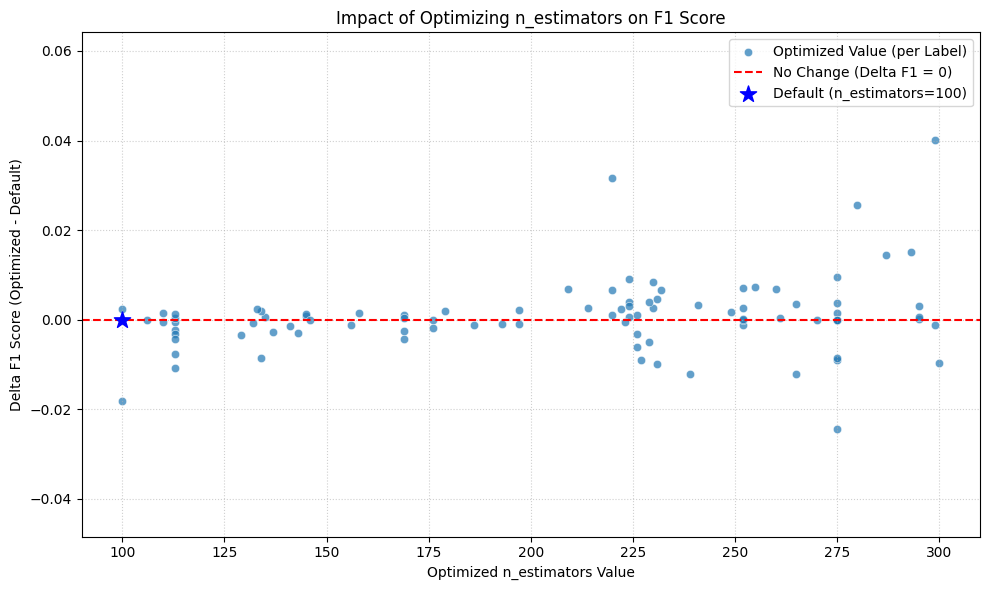

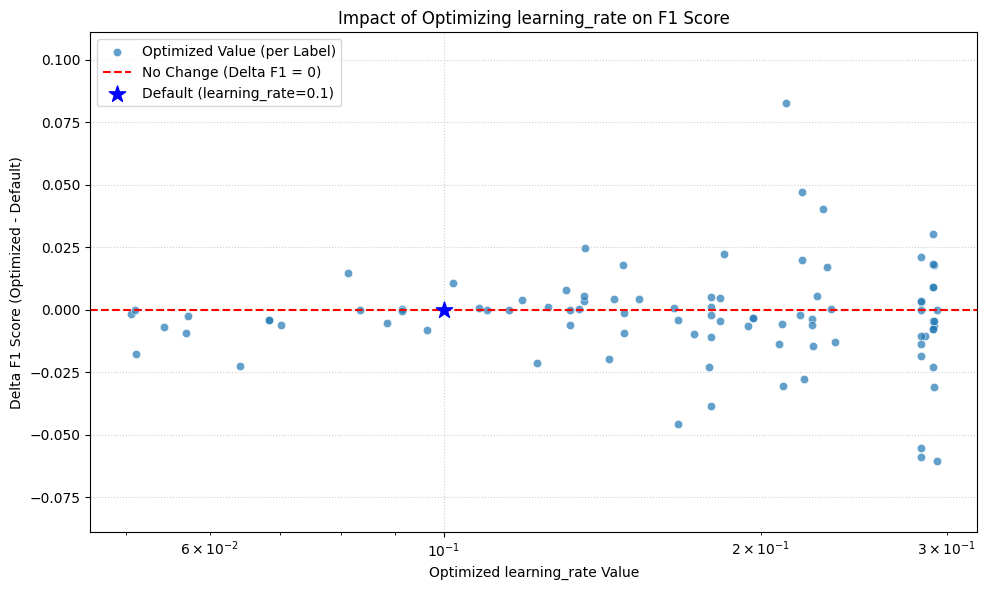

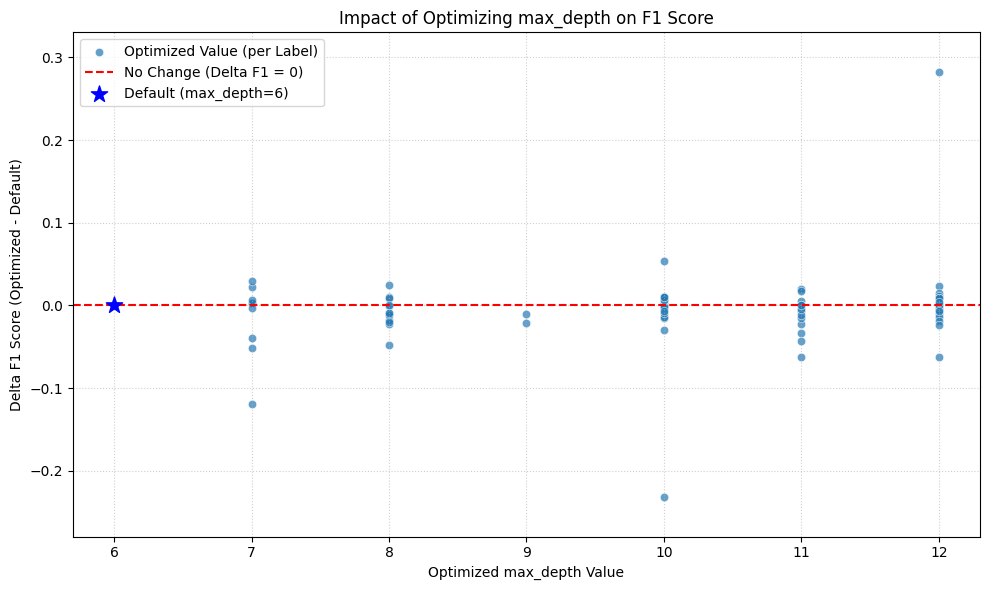

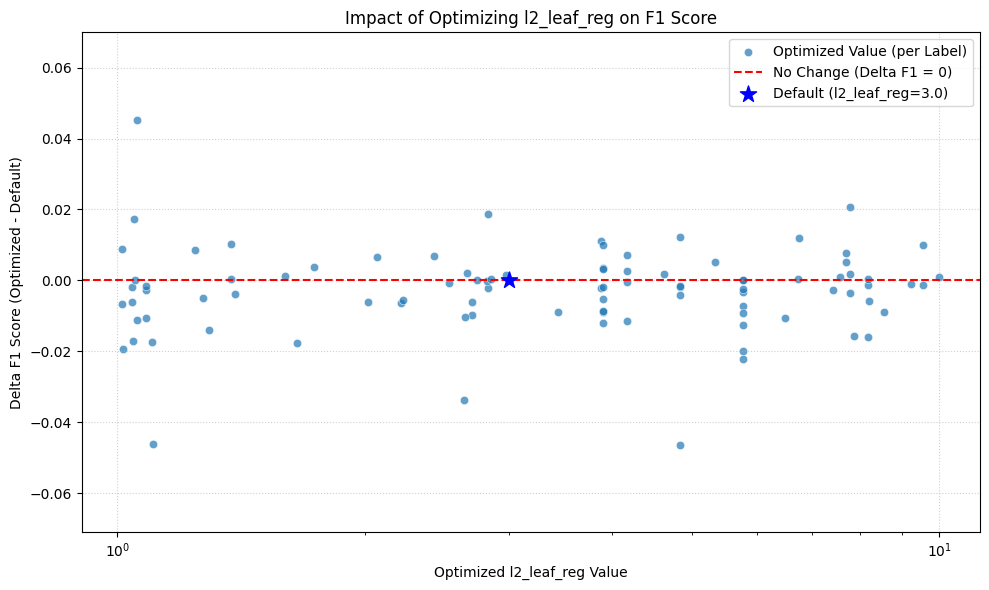


Delta F1 plots generated.


In [ ]:
# results_df = pd.DataFrame(results)
# results_df.to_csv("/content/drive/MyDrive/building_classification/默认vs遍历4个优化后参数依次在测试集上每个label的report.csv")
results_df = pd.read_csv("/content/drive/MyDrive/building_classification/testDataFrame.csv")
if 'error' in results_df.columns:
    error_labels = results_df[results_df['error'].notna()]['label'].tolist()
    if error_labels:
        print(f"\nWarning: Errors occurred during processing for labels: {error_labels}")
        results_df = results_df[results_df['error'].isna()].drop(columns=['error'])
    else:
        results_df = results_df.drop(columns=['error'], errors='ignore')


hyperparams_to_analyze = ['n_estimators', 'learning_rate', 'max_depth', 'l2_leaf_reg']

for hp in hyperparams_to_analyze:
    results_df[f'opt_{hp}_value'] = results_df['label'].map(
        lambda lbl: tuned_param_dict.get(lbl, {}).get(hp, DEFAULT_CATBOOST_PARAMS.get(hp))
    )
    if results_df[f'opt_{hp}_value'].isnull().any():
         results_df[f'opt_{hp}_value'].fillna(DEFAULT_CATBOOST_PARAMS.get(hp), inplace=True)


if 'f1_default_avg' in results_df.columns:
    for hp in hyperparams_to_analyze:
        opt_f1_col = f'f1_opt_{hp}_avg'
        delta_f1_col = f'delta_f1_{hp}'
        if opt_f1_col in results_df.columns:
            results_df[delta_f1_col] = results_df[opt_f1_col] - results_df['f1_default_avg']
        else:
            print(f"Warning: Optimized F1 column '{opt_f1_col}' not found. Cannot calculate delta F1.")
            results_df[delta_f1_col] = np.nan # Or 0 if preferred
else:
    print("Warning: 'f1_default_avg' column not found. Cannot calculate Delta F1 scores.")
    for hp in hyperparams_to_analyze:
        results_df[f'delta_f1_{hp}'] = np.nan


if 'f1_default_avg' in results_df.columns:
     results_df.dropna(subset=['f1_default_avg'], inplace=True)

if not results_df.empty:
    display_cols = ['label', 'f1_default_avg'] + \
                   [f'opt_{hp}_value' for hp in hyperparams_to_analyze] + \
                   [f'delta_f1_{hp}' for hp in hyperparams_to_analyze]



def plot_delta_f1(df, hp_value_col, delta_f1_col, hp_name, default_hp_value, use_log_scale=False):
    """Plots Optimized Hyperparameter Value vs. Delta F1, adding a marker for the default value."""
    if df.empty:
        print(f"Skipping Delta F1 plot for '{hp_name}': DataFrame is empty.")
        return
    if hp_value_col not in df.columns or delta_f1_col not in df.columns:
        print(f"Skipping Delta F1 plot for '{hp_name}': Columns missing ({hp_value_col} or {delta_f1_col}).")
        return

    # Drop rows where either the value or the delta is NaN for this specific plot
    plot_df = df[[hp_value_col, delta_f1_col]].dropna()
    if plot_df.empty:
        print(f"Skipping Delta F1 plot for '{hp_name}': No valid data points after dropping NaNs.")
        return

    plt.figure(figsize=(10, 6))

    # Plot the main scatter points for optimized values
    sns.scatterplot(data=plot_df, x=hp_value_col, y=delta_f1_col, alpha=0.7, label='Optimized Value (per Label)')

    # Add horizontal line at y=0
    plt.axhline(0, color='red', linestyle='--', label='No Change (Delta F1 = 0)')

    # --- Add the marker for the default parameter ---
    plt.scatter(
        x=default_hp_value,
        y=0,
        marker='*',        # Star marker
        color='blue',      # Blue color
        s=150,             # Size of the marker (adjust as needed)
        label=f'Default ({hp_name}={default_hp_value})', # Label for the legend
        zorder=5           # Ensure it's drawn on top
    )
    # --- End of marker addition ---

    plt.ylabel("Delta F1 Score (Optimized - Default)")
    plt.xlabel(f"Optimized {hp_name} Value")
    plt.title(f"Impact of Optimizing {hp_name} on F1 Score")

    # Set Y limits (e.g., -0.2 to 0.2, or based on data range)
    min_delta = plot_df[delta_f1_col].min()
    max_delta = plot_df[delta_f1_col].max()
    # Consider the default point (y=0) when setting limits
    min_delta = min(min_delta, -0.01) # Ensure 0 is not exactly at the edge if all deltas are positive
    max_delta = max(max_delta, 0.01)  # Ensure 0 is not exactly at the edge if all deltas are negative
    y_padding = max(abs(min_delta), abs(max_delta)) * 0.1 + 0.02
    plt.ylim(min_delta - y_padding, max_delta + y_padding)

    # Handle x-axis scale
    if use_log_scale:
        # Ensure all values are positive for log scale
        if (plot_df[hp_value_col] <= 0).any() or default_hp_value <= 0: # Check default too
            print(f"Warning: Cannot use log scale for {hp_name} due to non-positive values. Using linear scale.")
            plt.xscale('linear') # Explicitly set linear if log fails
        else:
            plt.xscale('log')
    else:
         plt.xscale('linear') # Ensure linear if not log

    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

if not results_df.empty:
    print("\nGenerating Delta F1 plots with default marker...")

    # Get default values
    default_n_estimators = DEFAULT_CATBOOST_PARAMS.get('n_estimators', 150) # Add fallback just in case
    default_lr = DEFAULT_CATBOOST_PARAMS.get('learning_rate', 0.1)
    default_depth = DEFAULT_CATBOOST_PARAMS.get('max_depth', 6)
    default_l2 = DEFAULT_CATBOOST_PARAMS.get('l2_leaf_reg', 3.0)

    # n_estimators vs Delta F1
    plot_delta_f1(results_df, 'opt_n_estimators_value', 'delta_f1_n_estimators', 'n_estimators',
                  default_hp_value=default_n_estimators, use_log_scale=False)

    # learning_rate vs Delta F1
    plot_delta_f1(results_df, 'opt_learning_rate_value', 'delta_f1_learning_rate', 'learning_rate',
                  default_hp_value=default_lr, use_log_scale=True)

    # max_depth vs Delta F1
    plot_delta_f1(results_df, 'opt_max_depth_value', 'delta_f1_max_depth', 'max_depth',
                  default_hp_value=default_depth, use_log_scale=False)

    # l2_leaf_reg vs Delta F1
    plot_delta_f1(results_df, 'opt_l2_leaf_reg_value', 'delta_f1_l2_leaf_reg', 'l2_leaf_reg',
                  default_hp_value=default_l2, use_log_scale=True)

    print("\nDelta F1 plots generated.")
else:
    print("\nSkipping Delta F1 plot generation as there are no valid results.")

